In [1]:
import pennylane as qml
import torch
import numpy as np
import random
import torch.nn as nn
from tqdm import tqdm

In [2]:
import functools
import inspect
import math
from collections.abc import Iterable
from typing import Callable, Dict, Union, Any

from pennylane import QNode

try:
    import torch
    from torch.nn import Module

    TORCH_IMPORTED = True
except ImportError:
    # The following allows this module to be imported even if PyTorch is not installed. Users
    # will instead see an ImportError when instantiating the TorchLayer.
    from unittest.mock import Mock

    Module = Mock
    TORCH_IMPORTED = False


class TorchLayer(Module):
    def __init__(self,qnode,weights):
        if not TORCH_IMPORTED:
            raise ImportError(
                "TorchLayer requires PyTorch. PyTorch can be installed using:\n"
                "pip install torch\nAlternatively, "
                "visit https://pytorch.org/get-started/locally/ for detailed "
                "instructions."
            )
        super().__init__()

        #weight_shapes = {
        #    weight: (tuple(size) if isinstance(size, Iterable) else () if size == 1 else (size,))
        #    for weight, size in weight_shapes.items()
        #}

        # validate the QNode signature, and convert to a Torch QNode.
        # TODO: update the docstring regarding changes to restrictions when tape mode is default.
        #self._signature_validation(qnode, weight_shapes)
        self.qnode = qnode
        self.qnode.interface = "torch"

        self.qnode_weights = weights

    def forward(self, inputs):  # pylint: disable=arguments-differ
        """Evaluates a forward pass through the QNode based upon input data and the initialized
        weights.

        Args:
            inputs (tensor): data to be processed

        Returns:
            tensor: output data
        """

        if len(inputs.shape) > 1:
            # If the input size is not 1-dimensional, unstack the input along its first dimension,
            # recursively call the forward pass on each of the yielded tensors, and then stack the
            # outputs back into the correct shape
            reconstructor = [self.forward(x) for x in torch.unbind(inputs)]
            return torch.stack(reconstructor)

        # If the input is 1-dimensional, calculate the forward pass as usual
        return self._evaluate_qnode(inputs)


    def _evaluate_qnode(self, x):
        """Evaluates the QNode for a single input datapoint.

        Args:
            x (tensor): the datapoint

        Returns:
            tensor: output datapoint
        """
        kwargs = {
            **{self.input_arg: x},
            **{arg: weight.to(x) for arg, weight in self.qnode_weights.items()},
        }
        res = self.qnode(**kwargs)

        if isinstance(res, torch.Tensor):
            return res.type(x.dtype)

        return torch.hstack(res).type(x.dtype)

    def __str__(self):
        detail = "<Quantum Torch Layer: func={}>"
        return detail.format(self.qnode.func.__name__)

    __repr__ = __str__
    _input_arg = "inputs"

    @property
    def input_arg(self):
        """Name of the argument to be used as the input to the Torch layer. Set to ``"inputs"``."""
        return self._input_arg

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_attention(alpha, img_shape=(8,8), patch_shape=(4,4)):
    """
    alpha: Attention values (torch tensor or numpy array)
    img_shape: Shape of the original image (height, width)
    patch_shape: Shape of the patch (height, width)
    """
    # Reshape alpha to match image shape
    alpha = alpha.detach().numpy() if isinstance(alpha, torch.Tensor) else alpha
    attention_map = np.mean(alpha, axis=0).reshape(patch_shape)  # Mean over the sequence
    
    # Normalize the attention map
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
    
    # Plot the attention map
    plt.figure(figsize=(6, 6))
    sns.heatmap(attention_map, annot=True, cmap="YlGnBu", cbar=True)
    plt.title("Attention Map")
    plt.show()

In [4]:
class QSAL_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D):
        super().__init__()
        self.seq_num=S
        self.init_params_Q=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_K=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.init_params_V=torch.nn.Parameter(torch.stack([(np.pi/4) * (2 * torch.randn(n*(D+2)) - 1) for _ in range(self.seq_num)]))
        self.num_q=n
        self.Denc=Denc
        self.D=D
        self.d=n*(Denc+2)
        self.dev = qml.device("default.qubit", wires=self.num_q)
        
        self.vqnod=qml.QNode(self.circuit_v, self.dev, interface="torch")
        self.qnod=qml.QNode(self.circuit_qk, self.dev, interface="torch")
        self.weight_v = [{"weights": self.init_params_V[i]} for i in range(self.seq_num)]
        self.weight_q = [{"weights": self.init_params_Q[i]} for i in range(self.seq_num)]
        self.weight_k = [{"weights": self.init_params_K[i]} for i in range(self.seq_num)]
        #self.v_linear ={} #[qml.qnn.TorchLayer(self.vqnod[i], self.weight_shapes) for i in range(self.seq_num)]
        #for i in range(self.seq_num):
        self.v_linear = [TorchLayer(self.vqnod, self.weight_v[i]) for i in range(self.seq_num)]
        self.q_linear = [TorchLayer(self.qnod, self.weight_q[i]) for i in range(self.seq_num)]
        self.k_linear = [TorchLayer(self.qnod, self.weight_k[i]) for i in range(self.seq_num)]
        #self.qqnod=[qml.QNode(self.circuit_qk, self.dev, interface="torch") for i in range(self.seq_num)]

    def random_op(self):
        a=random.randint(0, 4)
        if a==0:
            op=qml.Identity(0)
        elif a==1:
            op=qml.PauliX(0)
        elif a==2:
            op=qml.PauliY(0)
        else:
            op=qml.PauliZ(0)

        op_elimated=qml.Identity(0)
        for i in range(1,self.num_q):
            op_elimated=op_elimated@qml.Identity(i)
        Select_wrong=True
        while Select_wrong:
            for i in range(1,self.num_q):
                a=random.randint(0, 4)
                if a==0:
                    op=op@qml.Identity(i)
                elif a==1:
                    op=op@qml.PauliX(i)
                elif a==2:
                    op=op@qml.PauliY(i)
                else:
                    op=op@qml.PauliZ(i)
            if op!=op_elimated:
                Select_wrong=False
        return op

    def circuit_v(self,inputs,weights):
            op=self.random_op()
            # feature_map
            indx=0
            for j in range(self.num_q):
                qml.RX(inputs[indx],j)
                qml.RY(inputs[indx+1],j)
                indx+=2
            for i in range(self.Denc):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))

                for j in range(self.num_q):
                    qml.RY(inputs[indx],j)
                    indx+=1
            # Ansatz
            indx=0
            for j in range(self.num_q):
                qml.RX(weights[indx],j)
                qml.RY(weights[indx+1],j)
                indx+=2
            for i in range(self.D):
                for j in range(self.num_q):
                    qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
                for j in range(self.num_q):
                    #qc.rx(params[indx],j)
                    qml.RY(weights[indx],j)
                    indx+=1
            return [qml.expval(op) for i in range(self.d)] 

    def circuit_qk(self,inputs,weights):
        op=self.random_op()
        # feature_map
        indx=0
        for j in range(self.num_q):
            qml.RX(inputs[indx],j)
            qml.RY(inputs[indx+1],j)
            indx+=2
        for i in range(self.Denc):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))

            for j in range(self.num_q):
                qml.RY(inputs[indx],j)
                indx+=1
        # Ansatz
        indx=0
        for j in range(self.num_q):
            qml.RX(weights[indx],j)
            qml.RY(weights[indx+1],j)
            indx+=2
        for i in range(self.D):
            for j in range(self.num_q):
                qml.CNOT(wires=(j,(j+1)%self.num_q))
                
            for j in range(self.num_q):
                #qc.rx(params[indx],j)
                qml.RY(weights[indx],j)
                indx+=1
        return [qml.expval(qml.PauliZ(0))]

    def forward(self,input):

        Q_output=torch.stack([self.q_linear[i](input[:,i]) for i in range(self.seq_num)])
        K_output=torch.stack([self.k_linear[i](input[:,i]) for i in range(self.seq_num)])
        V_output=torch.stack([self.v_linear[i](input[:,i]) for i in range(self.seq_num)])
        
        batch_size=len(input)
        Q_output=Q_output.transpose(0,2).repeat((self.seq_num,1,1))
        K_output=K_output.transpose(0,2).repeat((self.seq_num,1,1)).transpose(0,2)
        #print(V_output.size())
        #Q_grid, K_grid=torch.meshgrid(Q_output, K_output, indexing='ij')
        alpha=torch.exp(-(Q_output-K_output)**2)
        alpha=alpha.transpose(0,1)
        
        print(f'alpha: {alpha}')
        # Example usage:
        visualize_attention(alpha)
        
        V_output=V_output.transpose(0,1)
        output=[]

        for i in range(self.seq_num):
            
            Sum_a=torch.sum(alpha[:,i,:],-1)
            div_sum_a=(1/Sum_a).repeat(self.d,self.seq_num,1).transpose(0,2)
            
            Sum_w=torch.sum(alpha[:,:,i].repeat((self.d,1,1)).transpose(0,2).transpose(0,1)*V_output*div_sum_a,1)
            output.append(Sum_w)
        return input+torch.stack(output).transpose(0,1)

class QSANN_pennylane(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.qsal_lst=[QSAL_pennylane(S,n,Denc,D) for _ in range(num_layers)]
        self.qnn=nn.Sequential(*self.qsal_lst)

    def forward(self,input):

        return self.qnn(input)

class QSANN_text_classifier(torch.nn.Module):
    def __init__(self,S,n,Denc,D,num_layers):
        """
        # input: input data
        # weight: trainable parameter
        # n: # of of qubits
        # d: embedding dimension which is equal to n(Denc+2)
        # Denc: the # number of layers for encoding 
        # D: the # of layers of variational layers
        # type "K": key, "Q": Query, "V": value
        """
        super().__init__()
        self.Qnn=QSANN_pennylane(S,n,Denc,D,num_layers)
        self.final_layer=nn.Linear(n*(Denc+2)*S, 10)
        self.final_layer=self.final_layer.float()

    def forward(self,input):

        x=self.Qnn(input)
        x=torch.flatten(x, start_dim=1)
        
        return self.final_layer(x)

In [5]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
digits = load_digits()
X, y = digits.images[0:200], digits.target[0:200]
X_train, X_test, y_train, y_test = train_test_split(X, y)

#train_mask = np.isin(y_train, [1, 7])
#X_train, y_train = X_train[train_mask], y_train[train_mask]

#test_mask = np.isin(y_test, [1, 7])
#X_test, y_test = X_test[test_mask], y_test[test_mask]

# X_train = X_train.reshape(X_train.shape[0], 4, 16)
# X_test = X_test.reshape(X_test.shape[0], 4, 16)

In [6]:
X_train.shape

(150, 8, 8)

In [7]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

2024-09-30 14:47:41.359105: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-30 14:47:41.455159: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 14:47:42.221033: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 14:47:42.509588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 14:47:42.895292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [8]:
# 4x4 크기로 겹치지 않게 패치로 나누는 함수
def split_into_non_overlapping_patches(image, patch_size=(4, 4)):
    patches = []
    for i in range(0, image.shape[0], patch_size[0]):
        for j in range(0, image.shape[1], patch_size[1]):
            patch = image[i:i+patch_size[0], j:j+patch_size[1]].flatten()
            patches.append(patch)
    return np.array(patches)

In [9]:
# 각 이미지를 4x4 겹치지 않는 패치로 나누기
X_train = np.array([split_into_non_overlapping_patches(img) for img in X_train])
X_test = np.array([split_into_non_overlapping_patches(img) for img in X_test])

In [10]:
# (283, 16, 2, 2)를 (283, 16, 4)로 변환
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [11]:
# # 이미지 패치 나누기 (2x2 크기 패치)
# patch_size = (2, 2)

# # 각 이미지를 개별적으로 패치로 나누기
# X_train = np.array([extract_patches_2d(img, patch_size) for img in X_train])
# X_test = np.array([extract_patches_2d(img, patch_size) for img in X_test])

In [12]:
X_train.shape

(150, 4, 16)

In [13]:
X_train

array([[[ 0.,  0.,  3., ...,  0.,  0.,  1.],
        [14.,  1.,  0., ..., 10.,  1.,  0.],
        [ 0.,  0.,  7., ...,  0.,  4., 12.],
        [16., 16.,  8., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  2., ...,  0.,  0.,  7.],
        [ 8.,  0.,  0., ..., 15.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  2., 15.],
        [ 0., 14.,  3., ..., 14., 13.,  2.]],

       [[ 0.,  0., 10., ...,  8., 12.,  0.],
        [10.,  0.,  0., ..., 14.,  1.,  0.],
        [ 0.,  8., 12., ...,  0.,  7., 12.],
        [ 0.,  7.,  8., ..., 12.,  4.,  0.]],

       ...,

       [[ 0.,  0.,  4., ...,  8., 12.,  0.],
        [11.,  0.,  0., ...,  8.,  6.,  0.],
        [ 0.,  8., 12., ...,  0.,  5., 16.],
        [ 0.,  8.,  8., ...,  8.,  0.,  0.]],

       [[ 0.,  0.,  9., ...,  3.,  8., 11.],
        [16., 16.,  5., ..., 16., 11.,  0.],
        [ 0.,  8., 16., ...,  0., 13., 10.],
        [15., 11.,  3., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  7., ...,  0.,  4.,  8.],
        [16., 16., 13., ..., 16.

In [14]:
    # def circuit_v(self,inputs,weights):
    #         op=self.random_op()
    #         # feature_map
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(inputs[indx],j)
    #             qml.RY(inputs[indx+1],j)
    #             indx+=2
    #         for i in range(self.Denc):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))

    #             for j in range(self.num_q):
    #                 qml.RY(inputs[indx],j)
    #                 indx+=1
    #         # Ansatz
    #         indx=0
    #         for j in range(self.num_q):
    #             qml.RX(weights[indx],j)
    #             qml.RY(weights[indx+1],j)
    #             indx+=2
    #         for i in range(self.D):
    #             for j in range(self.num_q):
    #                 qml.CNOT(wires=(j,(j+1)%self.num_q))
                    
    #             for j in range(self.num_q):
    #                 #qc.rx(params[indx],j)
    #                 qml.RY(weights[indx],j)
    #                 indx+=1
    #         return [qml.expval(op) for i in range(self.d)] 

In [15]:
model=QSANN_text_classifier(4, 4, 2, 1, 1)

# seq * (num_qubits) * (num_layers + 2)

In [16]:
optimizer = torch.optim.Adam(lr=0.01, params=model.parameters())

In [17]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

794


In [18]:
criterion = torch.nn.CrossEntropyLoss()

In [19]:
def multi_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    pred_soft = torch.log_softmax(preds, dim=1)
    _, pred_index = torch.max(pred_soft, dim=1)
    print(pred_index)
    y = [int(w.argmax()) for w in y]
    y = torch.tensor(y, dtype=float)
    print(y)
    correct_pred = (pred_index == y).float()
    #round predictions to the closest integer
    
    acc = correct_pred.sum()/len(correct_pred)

    return acc

In [20]:
torch.tensor(X_train)

tensor([[[ 0.,  0.,  3.,  ...,  0.,  0.,  1.],
         [14.,  1.,  0.,  ..., 10.,  1.,  0.],
         [ 0.,  0.,  7.,  ...,  0.,  4., 12.],
         [16., 16.,  8.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  2.,  ...,  0.,  0.,  7.],
         [ 8.,  0.,  0.,  ..., 15.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  2., 15.],
         [ 0., 14.,  3.,  ..., 14., 13.,  2.]],

        [[ 0.,  0., 10.,  ...,  8., 12.,  0.],
         [10.,  0.,  0.,  ..., 14.,  1.,  0.],
         [ 0.,  8., 12.,  ...,  0.,  7., 12.],
         [ 0.,  7.,  8.,  ..., 12.,  4.,  0.]],

        ...,

        [[ 0.,  0.,  4.,  ...,  8., 12.,  0.],
         [11.,  0.,  0.,  ...,  8.,  6.,  0.],
         [ 0.,  8., 12.,  ...,  0.,  5., 16.],
         [ 0.,  8.,  8.,  ...,  8.,  0.,  0.]],

        [[ 0.,  0.,  9.,  ...,  3.,  8., 11.],
         [16., 16.,  5.,  ..., 16., 11.,  0.],
         [ 0.,  8., 16.,  ...,  0., 13., 10.],
         [15., 11.,  3.,  ...,  0.,  0.,  0.]],

        [[ 0.,  0.,  7.,  ...,  0., 

  0%|          | 0/30 [00:00<?, ?it/s]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9921, 0.9584, 0.9979, 0.9502],
         [0.8706, 0.7869, 0.9451, 0.7715],
         [0.9910, 0.9559, 0.9984, 0.9475],
         [0.7001, 0.7943, 0.5853, 0.8093]],

        [[0.9726, 0.9991, 0.9846, 0.9583],
         [0.9424, 0.9978, 0.9601, 0.9229],
         [0.9804, 0.9969, 0.9903, 0.9680],
         [0.9721, 0.8755, 0.9568, 0.9836]],

        [[0.9973, 0.9733, 0.9902, 0.9373],
         [0.9993, 0.9807, 0.9945, 0.9249],
         [0.9712, 0.9226, 0.9534, 0.9819],
         [0.9939, 0.9988, 0.9991, 0.8626]],

        ...,

        [[0.9769, 0.9940, 0.9844, 0.9412],
         [0.9982, 0.9989, 0.9998, 0.9819],
         [0.9946, 1.0000, 0.9978, 0.9724],
         [0.9999, 0.9928, 0.9986, 0.9930]],

        [[0.9980, 0.9978, 0.9877, 0.9929],
         [1.0000, 0.9915, 0.9957, 0.9985],
         [0.9997, 0.9882, 0.9976, 0.9995],
         [0.9997, 0.9885, 0.9975, 0.9995]],

        [[0.9444, 0.9786, 0.8410, 0.8406],
         [0.9567, 0.9861, 0.8607, 0.8604],
         [1.0000, 0.991

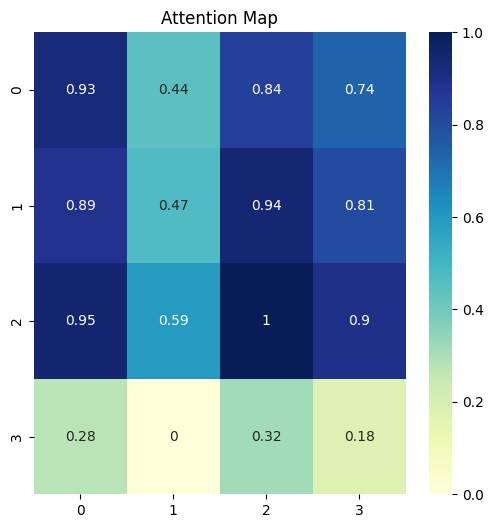

tensor([7, 9, 1, 7, 7, 9, 1, 1, 2, 9, 7, 2, 7, 1, 9, 7, 7, 7, 9, 7, 1, 7, 9, 1,
        2, 1, 1, 9, 9, 9, 1, 7, 7, 2, 9, 9, 9, 9, 2, 2, 7, 2, 9, 1, 7, 1, 2, 1,
        7, 7, 7, 9, 7, 1, 7, 7, 7, 1, 7, 9, 9, 9, 7, 9, 9, 1, 9, 2, 9, 9, 9, 9,
        7, 6, 1, 9, 8, 2, 9, 7, 2, 9, 9, 1, 9, 9, 2, 1, 9, 1, 9, 1, 1, 7, 9, 1,
        7, 9, 9, 7, 7, 9, 9, 2, 9, 7, 1, 7, 9, 7, 9, 2, 1, 7, 1, 9, 7, 1, 7, 8,
        7, 2, 1, 7, 1, 1, 7, 7, 2, 7, 2, 7, 7, 7, 7, 7, 7, 9, 7, 2, 2, 7, 7, 2,
        7, 9, 2, 1, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

  3%|▎         | 1/30 [00:51<25:01, 51.76s/it]

alpha: tensor([[[0.9713, 0.9679, 0.9947, 0.9185],
         [0.9996, 0.8714, 0.9864, 0.7928],
         [0.9744, 0.9644, 0.9960, 0.9132],
         [0.8276, 0.5387, 0.7530, 0.4470]],

        [[0.9972, 0.9968, 0.9852, 0.8890],
         [0.9971, 0.9975, 0.9489, 0.9458],
         [0.9822, 0.9812, 0.9983, 0.8353],
         [0.9970, 0.9965, 0.9857, 0.8876]],

        [[0.9679, 0.9833, 0.9649, 0.9959],
         [0.9992, 0.9995, 0.9987, 0.9922],
         [0.9882, 0.9967, 0.9863, 0.9999],
         [0.9999, 0.9985, 0.9996, 0.9891]],

        ...,

        [[0.9598, 0.9116, 0.8748, 0.9138],
         [0.9199, 0.9655, 0.9843, 0.9641],
         [0.9998, 0.9865, 0.9687, 0.9873],
         [1.0000, 0.9909, 0.9757, 0.9917]],

        [[0.9999, 0.9983, 0.9778, 0.9897],
         [0.9895, 0.9823, 0.9968, 0.9628],
         [0.9812, 0.9720, 0.9995, 0.9487],
         [0.9990, 0.9961, 0.9837, 0.9849]],

        [[0.9562, 0.7681, 0.9691, 0.8345],
         [0.9989, 0.8937, 1.0000, 0.9408],
         [0.9782, 0.976

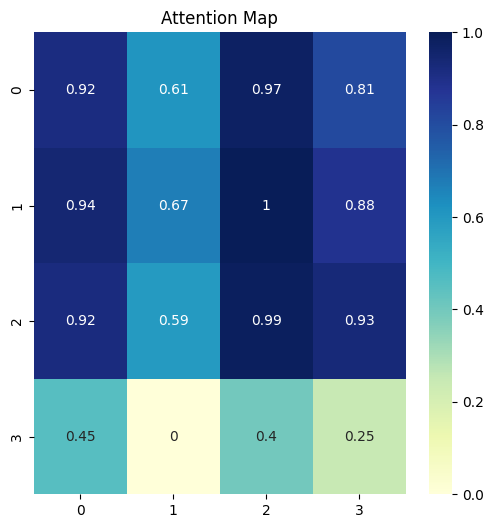

tensor([7, 8, 8, 6, 6, 6, 1, 1, 2, 9, 7, 8, 7, 1, 8, 6, 7, 6, 9, 7, 1, 7, 8, 2,
        2, 1, 1, 8, 8, 8, 1, 8, 6, 6, 6, 6, 0, 9, 8, 2, 8, 6, 8, 1, 8, 1, 8, 1,
        7, 8, 7, 8, 2, 8, 7, 6, 6, 8, 8, 6, 8, 9, 7, 6, 8, 6, 6, 0, 6, 9, 6, 9,
        8, 6, 8, 8, 8, 6, 8, 8, 8, 9, 8, 8, 6, 6, 2, 8, 8, 8, 9, 8, 8, 8, 8, 8,
        1, 9, 9, 8, 7, 8, 2, 2, 1, 7, 8, 8, 9, 7, 6, 0, 8, 7, 8, 6, 6, 1, 6, 8,
        8, 2, 1, 8, 1, 1, 8, 8, 2, 7, 8, 7, 8, 8, 7, 8, 7, 6, 6, 2, 2, 6, 6, 2,
        7, 2, 2, 1, 8, 8])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

  7%|▋         | 2/30 [01:46<25:00, 53.58s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9693, 0.7072, 0.9739, 0.9076],
         [1.0000, 0.5584, 0.9999, 0.7896],
         [0.9793, 0.6803, 0.9831, 0.8888],
         [0.4528, 0.9845, 0.4640, 0.8506]],

        [[1.0000, 0.9447, 0.9689, 0.9781],
         [1.0000, 0.9438, 0.9682, 0.9787],
         [0.9984, 0.9228, 0.9517, 0.9893],
         [0.8585, 0.9786, 0.9577, 0.7516]],

        [[0.9897, 0.9998, 0.6930, 0.9963],
         [0.9950, 0.9659, 0.8290, 0.9875],
         [0.9826, 0.9997, 0.6671, 0.9917],
         [0.9999, 0.9884, 0.7702, 0.9988]],

        ...,

        [[0.9983, 0.9657, 0.8534, 0.9997],
         [0.9058, 0.8086, 0.9847, 0.9362],
         [0.9821, 0.9999, 0.7200, 0.9638],
         [0.9854, 0.9309, 0.9041, 0.9960]],

        [[0.9517, 0.9823, 0.9181, 0.9663],
         [0.9989, 0.9969, 0.9895, 1.0000],
         [0.9994, 0.9960, 0.9910, 0.9999],
         [0.9988, 0.9849, 0.9988, 0.9948]],

        [[0.9265, 0.9038, 0.8496, 0.9940],
         [0.9980, 1.0000, 0.9932, 0.9423],
         [0.9998, 0.999

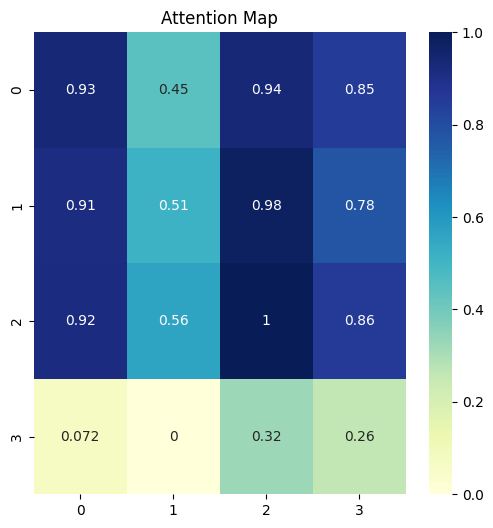

tensor([4, 5, 8, 6, 6, 6, 2, 1, 0, 6, 4, 0, 4, 2, 0, 0, 0, 6, 0, 4, 0, 4, 8, 0,
        2, 0, 2, 8, 8, 6, 1, 5, 6, 0, 6, 6, 0, 9, 8, 0, 4, 6, 8, 0, 4, 2, 8, 6,
        4, 0, 4, 5, 4, 8, 4, 4, 4, 0, 4, 6, 8, 5, 0, 6, 8, 6, 6, 0, 6, 5, 6, 6,
        4, 5, 4, 4, 8, 6, 4, 4, 4, 0, 8, 8, 5, 6, 0, 8, 8, 8, 5, 8, 8, 8, 8, 8,
        0, 0, 9, 8, 4, 5, 2, 0, 0, 4, 8, 4, 0, 4, 6, 0, 0, 7, 8, 6, 6, 0, 4, 4,
        8, 5, 1, 4, 0, 2, 8, 8, 4, 4, 4, 4, 4, 4, 4, 0, 4, 6, 4, 5, 4, 6, 4, 0,
        4, 2, 5, 2, 8, 5])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 10%|█         | 3/30 [02:34<22:54, 50.92s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8945, 0.7112, 0.9838, 0.9366],
         [0.6942, 0.4822, 0.8536, 0.9998],
         [0.8664, 0.6736, 0.9707, 0.9565],
         [0.3770, 0.2162, 0.5430, 0.8535]],

        [[0.9439, 0.9867, 0.9977, 0.8361],
         [0.9959, 0.9964, 0.9510, 0.9409],
         [0.9430, 0.9862, 0.9979, 0.8346],
         [0.9648, 0.9063, 0.7961, 1.0000]],

        [[0.9766, 0.9207, 0.9433, 0.8897],
         [0.9999, 0.9854, 0.9943, 0.7728],
         [0.9948, 0.9585, 0.9747, 0.8359],
         [0.9992, 0.9891, 0.9965, 0.7597]],

        ...,

        [[0.9937, 0.9928, 0.8496, 0.9571],
         [0.9994, 0.9651, 0.7733, 0.9888],
         [1.0000, 0.9712, 0.7868, 0.9849],
         [0.9958, 0.9487, 0.7404, 0.9958]],

        [[0.8359, 0.7948, 0.7705, 0.7900],
         [0.9830, 0.9944, 0.9981, 0.9953],
         [0.9652, 0.9826, 0.9898, 0.9842],
         [0.9989, 0.9995, 0.9971, 0.9992]],

        [[0.9698, 0.9564, 0.9818, 0.9055],
         [0.9561, 0.9696, 0.9387, 0.9948],
         [0.9724, 0.983

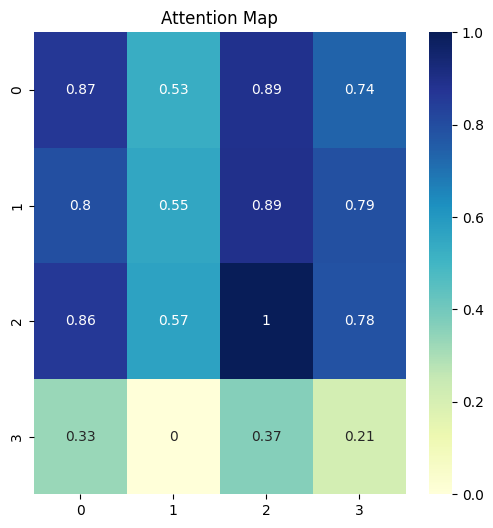

tensor([4, 5, 0, 5, 2, 6, 0, 0, 0, 5, 4, 0, 4, 0, 0, 0, 0, 2, 0, 5, 0, 4, 5, 0,
        2, 0, 0, 2, 5, 5, 0, 5, 5, 5, 0, 5, 0, 5, 4, 0, 5, 5, 4, 0, 5, 0, 0, 0,
        4, 0, 4, 5, 4, 8, 4, 5, 5, 0, 4, 5, 5, 5, 3, 4, 8, 6, 5, 0, 5, 5, 5, 0,
        5, 5, 4, 5, 5, 5, 4, 4, 5, 0, 2, 2, 5, 6, 0, 4, 5, 5, 5, 4, 8, 4, 5, 8,
        0, 5, 9, 3, 4, 5, 0, 5, 0, 4, 5, 5, 0, 4, 5, 0, 0, 5, 5, 5, 6, 0, 4, 5,
        5, 5, 0, 5, 0, 0, 4, 2, 4, 4, 4, 4, 4, 4, 4, 5, 4, 6, 4, 5, 5, 3, 4, 0,
        4, 2, 5, 0, 0, 5])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 13%|█▎        | 4/30 [03:22<21:37, 49.90s/it]

alpha: tensor([[[0.9628, 0.7095, 0.9985, 0.9347],
         [0.9994, 0.8414, 0.9574, 0.9920],
         [0.9719, 0.7308, 0.9959, 0.9468],
         [0.4855, 0.2142, 0.6835, 0.4328]],

        [[0.9959, 0.9308, 0.9514, 0.6934],
         [0.9328, 0.9954, 0.9994, 0.8483],
         [0.9824, 0.9612, 0.9765, 0.7500],
         [0.9824, 0.8052, 0.8377, 0.5249]],

        [[0.9674, 0.8878, 0.9996, 0.9954],
         [0.9998, 0.9777, 0.9702, 0.9840],
         [0.9471, 0.8549, 0.9948, 0.9860],
         [0.9980, 0.9861, 0.9585, 0.9750]],

        ...,

        [[0.9659, 0.9869, 0.8559, 0.9956],
         [0.9937, 0.9774, 0.9836, 0.9608],
         [0.9108, 0.9467, 0.7681, 0.9662],
         [0.9956, 1.0000, 0.9276, 0.9971]],

        [[0.8948, 0.9826, 0.8065, 0.8713],
         [0.9830, 0.9951, 0.9341, 0.9720],
         [0.9980, 0.9416, 0.9926, 1.0000],
         [0.9966, 0.9797, 0.9652, 0.9909]],

        [[0.9227, 0.8044, 0.9018, 0.9814],
         [0.9954, 0.9391, 0.9889, 0.9938],
         [0.9905, 0.924

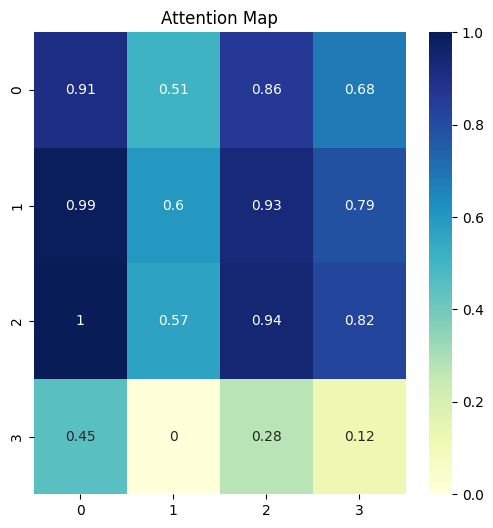

tensor([4, 5, 0, 5, 2, 2, 0, 0, 0, 5, 4, 0, 7, 0, 0, 3, 3, 2, 0, 4, 0, 5, 3, 0,
        2, 0, 0, 2, 5, 5, 0, 5, 3, 5, 3, 5, 0, 9, 2, 0, 5, 5, 4, 0, 5, 0, 0, 0,
        3, 5, 4, 5, 4, 6, 4, 3, 5, 3, 5, 2, 5, 5, 3, 2, 8, 2, 5, 0, 5, 5, 5, 0,
        5, 5, 3, 3, 5, 5, 4, 4, 4, 0, 2, 2, 5, 2, 0, 3, 5, 5, 5, 4, 3, 3, 5, 2,
        0, 5, 9, 3, 4, 5, 2, 5, 0, 4, 5, 5, 0, 4, 5, 0, 0, 5, 5, 5, 2, 0, 3, 5,
        5, 5, 0, 5, 0, 0, 2, 2, 4, 3, 4, 4, 4, 4, 4, 5, 4, 6, 3, 5, 5, 3, 3, 0,
        4, 2, 5, 0, 3, 5])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 17%|█▋        | 5/30 [04:11<20:33, 49.35s/it]

alpha: tensor([[[0.9680, 0.9165, 0.9550, 0.9233],
         [0.9082, 0.8345, 0.8880, 0.8435],
         [0.9812, 0.9382, 0.9709, 0.9441],
         [0.5223, 0.4282, 0.4937, 0.4384]],

        [[0.9981, 0.9977, 0.8822, 0.9472],
         [0.9660, 0.9912, 0.9563, 0.8685],
         [0.9441, 0.9783, 0.9755, 0.8316],
         [0.9017, 0.9485, 0.9943, 0.7700]],

        [[0.9773, 0.9859, 0.9183, 0.9042],
         [0.9963, 0.9914, 0.7756, 0.9890],
         [0.9489, 0.9341, 0.6363, 0.9960],
         [1.0000, 0.9986, 0.8175, 0.9746]],

        ...,

        [[0.9975, 0.9599, 0.8256, 0.9704],
         [0.9139, 0.9977, 0.6231, 0.8361],
         [0.9997, 0.9302, 0.8713, 0.9887],
         [0.9995, 0.9487, 0.8449, 0.9789]],

        [[0.9580, 0.9997, 0.7729, 0.9070],
         [0.9995, 0.9554, 0.9260, 0.9933],
         [0.9941, 0.9872, 0.8675, 0.9675],
         [0.9988, 0.9761, 0.8936, 0.9806]],

        [[0.9912, 0.9559, 1.0000, 0.9699],
         [0.9978, 0.9949, 0.9801, 0.9989],
         [0.9971, 0.970

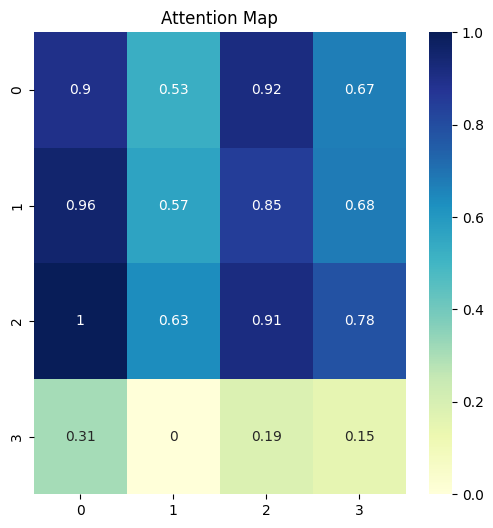

tensor([7, 9, 0, 3, 2, 3, 0, 0, 1, 5, 7, 4, 7, 0, 0, 3, 3, 3, 0, 4, 0, 2, 3, 0,
        2, 0, 0, 2, 2, 5, 0, 5, 3, 1, 3, 5, 0, 9, 2, 4, 4, 5, 4, 0, 2, 0, 4, 0,
        3, 3, 2, 5, 4, 6, 3, 3, 5, 3, 3, 2, 6, 5, 3, 3, 8, 3, 5, 0, 5, 3, 3, 3,
        3, 5, 3, 3, 8, 5, 4, 4, 4, 0, 6, 2, 5, 3, 1, 3, 5, 5, 9, 3, 6, 3, 6, 2,
        3, 5, 9, 3, 2, 5, 3, 3, 0, 4, 5, 5, 0, 4, 5, 1, 0, 3, 5, 3, 3, 0, 3, 4,
        7, 5, 1, 3, 0, 0, 2, 2, 4, 2, 4, 2, 6, 3, 3, 3, 3, 7, 3, 5, 3, 3, 3, 1,
        4, 2, 5, 0, 3, 3])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 20%|██        | 6/30 [04:59<19:36, 49.02s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9598, 0.7120, 0.9993, 0.9509],
         [0.8770, 0.8360, 0.9824, 0.9958],
         [0.9710, 0.6859, 0.9967, 0.9368],
         [0.7954, 0.2024, 0.6064, 0.4405]],

        [[0.9994, 0.9970, 0.9458, 0.8739],
         [0.9720, 0.9920, 0.8655, 0.7701],
         [0.9967, 0.9995, 0.9301, 0.8520],
         [0.8710, 0.9180, 0.7118, 0.6005]],

        [[0.9973, 0.9997, 0.9868, 0.9736],
         [0.9932, 0.9772, 0.9395, 0.9992],
         [0.9942, 0.9999, 0.9918, 0.9653],
         [0.9993, 0.9910, 0.9634, 0.9927]],

        ...,

        [[0.9894, 0.9996, 0.9805, 0.9476],
         [0.9243, 0.8765, 0.9425, 0.9772],
         [0.9791, 0.9494, 0.9884, 0.9997],
         [0.9992, 0.9970, 0.9958, 0.9758]],

        [[0.9704, 0.9097, 0.7436, 0.9719],
         [0.9916, 0.9501, 0.8072, 0.9924],
         [0.9915, 0.9499, 0.8068, 0.9923],
         [0.9999, 0.9843, 0.8770, 0.9998]],

        [[0.8832, 0.9825, 0.9208, 0.9076],
         [0.9888, 0.9872, 0.9983, 0.9958],
         [1.0000, 0.954

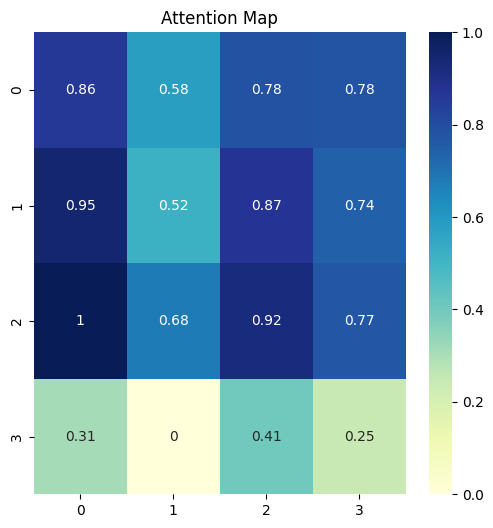

tensor([7, 9, 0, 3, 2, 3, 0, 0, 1, 5, 7, 4, 7, 0, 4, 3, 3, 7, 1, 4, 0, 2, 6, 0,
        5, 0, 0, 5, 2, 5, 0, 5, 3, 1, 3, 5, 0, 9, 2, 4, 4, 1, 8, 0, 2, 0, 4, 0,
        3, 7, 2, 5, 1, 6, 7, 3, 1, 3, 2, 2, 6, 5, 3, 1, 8, 6, 5, 1, 5, 3, 3, 3,
        2, 5, 6, 6, 8, 5, 4, 7, 4, 9, 6, 2, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        3, 9, 9, 3, 2, 5, 3, 1, 3, 7, 5, 2, 9, 4, 5, 1, 0, 7, 8, 3, 3, 0, 3, 4,
        7, 1, 1, 3, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 3, 2, 7, 2, 1, 1, 3, 3, 1,
        4, 2, 1, 0, 3, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 23%|██▎       | 7/30 [05:53<19:21, 50.52s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9930, 0.7033, 0.9954, 0.9059],
         [0.8975, 0.8859, 0.9067, 0.9952],
         [0.9846, 0.7371, 0.9883, 0.9280],
         [0.7106, 0.2037, 0.6973, 0.3809]],

        [[0.9877, 0.9863, 0.9598, 0.9603],
         [0.9190, 0.9157, 0.9995, 0.8651],
         [0.9311, 0.9280, 0.9978, 0.8802],
         [0.8131, 0.8085, 0.9803, 0.7430]],

        [[0.9813, 0.9519, 0.9960, 0.8683],
         [0.9985, 0.9848, 0.9988, 0.7987],
         [0.8794, 0.8218, 0.9225, 0.9763],
         [0.9992, 0.9875, 0.9978, 0.7898]],

        ...,

        [[0.9983, 0.9630, 0.9944, 0.9871],
         [0.9993, 0.9842, 0.9999, 0.9979],
         [0.8820, 0.7735, 0.8605, 0.8335],
         [1.0000, 0.9781, 0.9991, 0.9953]],

        [[0.9946, 0.9980, 0.9636, 0.9980],
         [0.9982, 0.9944, 0.9742, 0.9942],
         [0.9741, 0.9981, 0.9241, 0.9981],
         [1.0000, 0.9858, 0.9863, 0.9856]],

        [[0.9942, 0.9993, 0.9184, 0.9997],
         [1.0000, 0.9899, 0.9537, 0.9915],
         [0.9969, 0.975

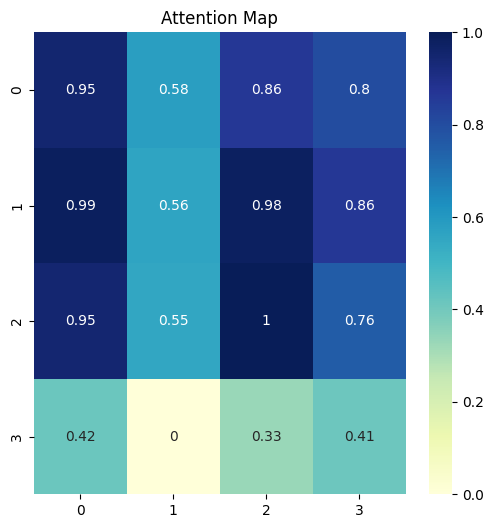

tensor([7, 9, 0, 3, 7, 3, 0, 0, 1, 5, 7, 4, 7, 0, 4, 3, 7, 7, 9, 4, 0, 2, 6, 1,
        5, 0, 0, 5, 8, 5, 0, 4, 2, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        3, 7, 2, 5, 1, 6, 7, 3, 1, 3, 8, 2, 6, 5, 3, 1, 8, 6, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 8, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 9, 7, 2, 5, 3, 1, 9, 7, 5, 6, 9, 4, 5, 1, 0, 7, 8, 3, 7, 0, 3, 4,
        7, 1, 1, 7, 0, 0, 7, 2, 4, 2, 4, 2, 6, 8, 7, 7, 7, 7, 2, 1, 1, 3, 7, 1,
        4, 2, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 27%|██▋       | 8/30 [06:46<18:51, 51.41s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9756, 0.9331, 0.9848, 0.9377],
         [0.9999, 0.8308, 0.9981, 0.9926],
         [0.9755, 0.9332, 0.9848, 0.9376],
         [0.5345, 0.8713, 0.5629, 0.4545]],

        [[0.9981, 0.9860, 0.9714, 0.9114],
         [0.9966, 0.9892, 0.9761, 0.9194],
         [0.9827, 0.9167, 0.8870, 0.7937],
         [0.9983, 0.9593, 0.9369, 0.8592]],

        [[0.9173, 0.8867, 0.9974, 0.9746],
         [0.9974, 0.9892, 0.9639, 0.9933],
         [0.9941, 0.9994, 0.9028, 0.9568],
         [0.9993, 0.9993, 0.9301, 0.9749]],

        ...,

        [[0.9937, 0.9991, 0.9440, 0.9229],
         [0.9419, 0.9819, 0.8486, 0.8179],
         [0.9622, 0.9108, 0.9987, 0.9999],
         [0.9970, 0.9733, 0.9890, 0.9782]],

        [[0.8933, 0.9395, 0.9951, 0.8241],
         [1.0000, 0.9931, 0.9332, 0.9886],
         [0.9995, 0.9960, 0.9427, 0.9840],
         [1.0000, 0.9922, 0.9306, 0.9897]],

        [[0.9245, 0.8634, 0.8832, 0.9184],
         [0.9961, 0.9983, 0.9999, 0.9974],
         [0.9997, 0.985

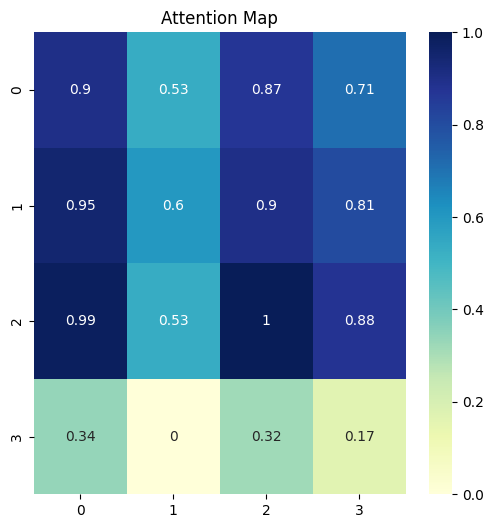

tensor([7, 9, 0, 3, 7, 9, 0, 0, 1, 9, 7, 4, 7, 0, 4, 7, 7, 7, 9, 4, 0, 2, 6, 1,
        5, 0, 0, 8, 8, 5, 0, 8, 2, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 5, 1, 6, 7, 3, 1, 3, 8, 9, 6, 9, 7, 1, 8, 6, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 8, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 8, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 9, 7, 2, 8, 3, 1, 9, 7, 5, 6, 9, 4, 5, 1, 0, 7, 8, 5, 7, 0, 3, 4,
        7, 1, 1, 7, 0, 0, 7, 2, 4, 2, 4, 2, 6, 8, 7, 7, 7, 7, 8, 1, 1, 3, 7, 1,
        4, 8, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 30%|███       | 9/30 [07:39<18:10, 51.91s/it]

alpha: tensor([[[0.9960, 0.9265, 0.9867, 0.9517],
         [0.9920, 0.8314, 0.9301, 0.9952],
         [0.9909, 0.9421, 0.9930, 0.9372],
         [0.7325, 0.4466, 0.5807, 0.8528]],

        [[0.9940, 0.9963, 0.9995, 0.9294],
         [0.9902, 0.9868, 0.9616, 0.8188],
         [0.9973, 0.9987, 0.9978, 0.9161],
         [0.9967, 0.9946, 0.9759, 0.8483]],

        [[0.9412, 0.9880, 1.0000, 0.9180],
         [0.9905, 0.9985, 0.9783, 0.8233],
         [0.9970, 0.9642, 0.9139, 0.7035],
         [0.9985, 0.9696, 0.9221, 0.7162]],

        ...,

        [[0.9989, 0.9883, 0.9634, 0.9837],
         [0.9363, 0.9677, 0.9907, 0.8397],
         [0.9980, 0.9991, 0.9868, 0.9585],
         [0.9867, 0.9641, 0.9268, 0.9979]],

        [[1.0000, 0.9936, 0.9418, 0.9943],
         [0.9996, 0.9910, 0.9485, 0.9918],
         [0.9937, 0.9762, 0.9716, 0.9774],
         [0.9908, 0.9996, 0.8876, 0.9994]],

        [[0.9237, 0.7548, 0.8583, 0.8928],
         [0.9696, 0.8351, 0.9220, 0.9481],
         [0.9750, 0.992

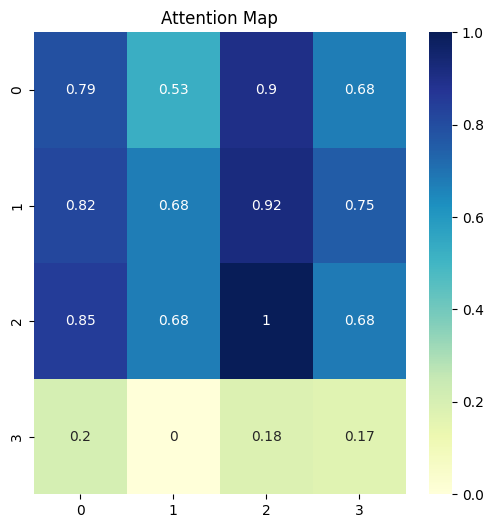

tensor([7, 9, 0, 3, 7, 9, 0, 0, 1, 9, 7, 4, 7, 0, 4, 7, 7, 7, 9, 4, 0, 2, 6, 1,
        5, 0, 0, 5, 8, 5, 0, 8, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 1, 6, 2, 8, 1, 9, 8, 9, 6, 9, 7, 8, 8, 6, 5, 1, 5, 9, 9, 9,
        8, 5, 6, 6, 8, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 8, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 9, 7, 2, 8, 9, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 8, 5, 7, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 7, 8, 1, 1, 7, 7, 1,
        4, 8, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 33%|███▎      | 10/30 [08:36<17:52, 53.64s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9922, 0.6333, 0.9907, 0.9884],
         [0.9723, 0.8384, 0.8832, 0.8760],
         [0.9965, 0.6579, 0.9844, 0.9815],
         [0.5496, 0.1567, 0.7069, 0.7163]],

        [[0.9352, 0.9937, 0.8680, 0.9891],
         [0.9409, 0.9954, 0.8757, 0.9865],
         [0.9473, 0.9971, 0.8846, 0.9830],
         [0.9662, 0.8756, 0.9954, 0.7398]],

        [[0.9744, 0.9907, 0.8206, 0.9194],
         [0.9942, 0.9803, 0.9580, 0.9973],
         [0.9754, 0.9517, 0.9843, 0.9992],
         [0.9988, 0.9901, 0.9401, 0.9913]],

        ...,

        [[0.9980, 0.9651, 0.9783, 0.9528],
         [0.9943, 0.9755, 0.9864, 0.9391],
         [0.9444, 0.8002, 0.8299, 0.9959],
         [0.9991, 0.9334, 0.9518, 0.9790]],

        [[0.9203, 0.9135, 0.9986, 0.9462],
         [0.9830, 0.9861, 0.8642, 0.9667],
         [0.9735, 0.9694, 0.9924, 0.9878],
         [0.9988, 0.9995, 0.9215, 0.9923]],

        [[0.9463, 0.9962, 0.8257, 0.9931],
         [0.9530, 0.7665, 0.9997, 0.8712],
         [0.9986, 0.894

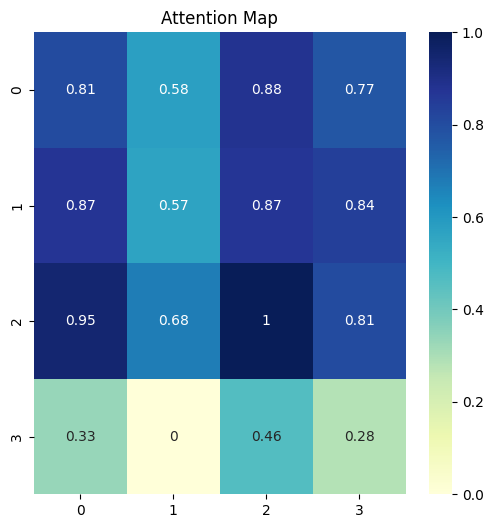

tensor([7, 9, 0, 3, 7, 9, 0, 0, 1, 9, 7, 4, 7, 0, 4, 7, 7, 7, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 8, 8, 5, 0, 8, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 1, 6, 2, 8, 1, 9, 8, 9, 6, 9, 7, 8, 8, 8, 5, 1, 5, 9, 9, 9,
        8, 5, 6, 6, 8, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 8, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 9, 7, 2, 8, 9, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 8, 5, 7, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 7, 8, 1, 1, 8, 7, 1,
        4, 8, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 37%|███▋      | 11/30 [09:30<17:01, 53.77s/it]

alpha: tensor([[[0.9964, 0.9259, 0.9997, 0.9253],
         [0.9426, 0.9912, 0.9727, 0.9910],
         [0.9948, 0.9324, 1.0000, 0.9318],
         [0.6666, 0.3873, 0.6009, 0.3865]],

        [[0.9902, 0.9713, 0.9367, 0.6646],
         [0.9937, 0.9999, 0.9941, 0.8088],
         [0.9879, 0.9985, 0.9979, 0.8316],
         [0.9726, 0.9910, 0.9999, 0.8700]],

        [[0.9679, 0.9296, 0.8638, 0.9988],
         [0.9997, 0.9947, 0.9663, 0.9737],
         [0.9760, 0.9415, 0.8796, 0.9999],
         [0.9883, 0.9615, 0.9080, 0.9986]],

        ...,

        [[0.9688, 0.9331, 0.7936, 0.9999],
         [0.9968, 0.9800, 0.8786, 0.9835],
         [0.9877, 0.9621, 0.8425, 0.9944],
         [0.9996, 0.9957, 0.9231, 0.9585]],

        [[0.8835, 0.9174, 0.9308, 0.8438],
         [0.9769, 0.9911, 0.9953, 0.9556],
         [0.9977, 0.9888, 0.9827, 0.9998],
         [0.9942, 0.9820, 0.9746, 0.9997]],

        [[0.9739, 0.9607, 0.9703, 0.9966],
         [0.9887, 0.9953, 0.9910, 0.9565],
         [1.0000, 0.998

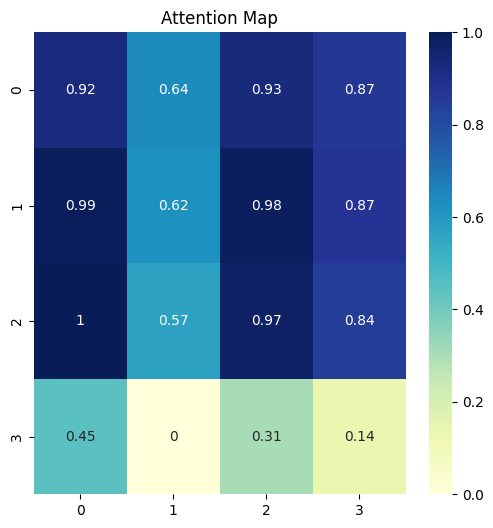

tensor([7, 9, 0, 3, 2, 9, 0, 0, 1, 9, 2, 4, 7, 0, 4, 7, 7, 7, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 8, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 1, 6, 2, 8, 1, 9, 8, 2, 6, 9, 7, 8, 8, 8, 5, 1, 5, 9, 3, 3,
        8, 5, 6, 6, 8, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 9, 7, 2, 8, 9, 1, 9, 2, 5, 8, 9, 4, 5, 1, 0, 7, 8, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 7, 8, 1, 1, 8, 7, 1,
        4, 8, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 40%|████      | 12/30 [10:24<16:04, 53.58s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9962, 0.9297, 0.9999, 0.9332],
         [0.9537, 0.8341, 0.9735, 0.8391],
         [0.9931, 0.9188, 0.9992, 0.9225],
         [0.5792, 0.4078, 0.6254, 0.4133]],

        [[0.9953, 0.9981, 0.9458, 0.9683],
         [0.9942, 0.9974, 0.9425, 0.9709],
         [0.9976, 0.9945, 0.9862, 0.9153],
         [0.8785, 0.8620, 0.9635, 0.6907]],

        [[0.9948, 0.9611, 0.9666, 0.9621],
         [1.0000, 0.9836, 0.9871, 0.9313],
         [0.9730, 0.9985, 0.9971, 0.8281],
         [0.9987, 0.9740, 0.9785, 0.9470]],

        ...,

        [[0.9883, 0.9988, 0.8867, 1.0000],
         [0.9100, 0.8168, 0.9953, 0.8383],
         [0.9829, 0.9999, 0.8720, 0.9997],
         [0.9962, 0.9935, 0.9137, 0.9974]],

        [[0.9040, 0.9254, 0.8330, 0.8163],
         [0.9869, 0.9766, 1.0000, 0.9997],
         [0.9960, 0.9994, 0.9705, 0.9623],
         [0.9997, 0.9996, 0.9837, 0.9774]],

        [[0.8953, 0.7385, 0.9234, 0.7559],
         [0.9757, 0.9963, 0.9580, 0.9984],
         [0.9985, 0.968

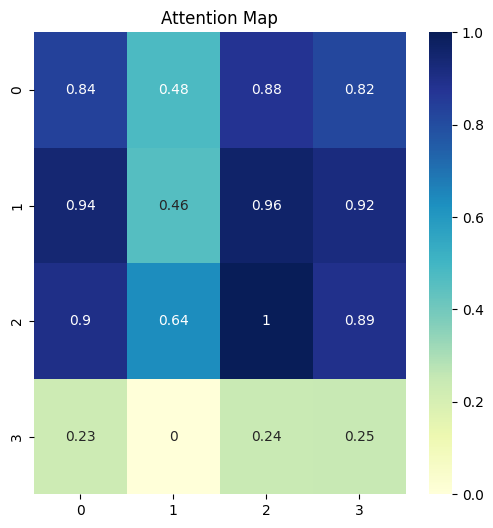

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 9, 2, 4, 7, 0, 4, 7, 7, 7, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 1, 6, 2, 8, 1, 9, 8, 3, 6, 9, 7, 8, 8, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 9, 7, 2, 8, 9, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 8, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 7, 2, 1, 1, 8, 7, 1,
        4, 8, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 43%|████▎     | 13/30 [11:15<14:58, 52.87s/it]

alpha: tensor([[[0.9603, 0.7209, 0.9953, 0.9532],
         [0.8702, 0.8518, 0.9438, 0.9978],
         [0.9765, 0.6817, 0.9995, 0.9318],
         [0.5221, 0.9989, 0.6350, 0.8616]],

        [[0.9173, 0.9924, 0.8672, 0.6619],
         [0.9868, 0.9317, 0.9612, 0.8064],
         [0.9928, 0.9160, 0.9719, 0.8285],
         [0.9708, 0.9572, 0.9367, 0.7625]],

        [[0.9669, 0.9964, 0.9999, 0.9888],
         [0.9975, 0.9947, 0.9798, 0.9993],
         [0.9939, 0.9603, 0.9290, 0.9761],
         [0.9954, 0.9641, 0.9339, 0.9790]],

        ...,

        [[0.9819, 0.9892, 0.9370, 0.9548],
         [0.9200, 0.9976, 0.8462, 0.8729],
         [0.9318, 0.9993, 0.8618, 0.8873],
         [0.9999, 0.9403, 0.9877, 0.9949]],

        [[0.9006, 0.8889, 0.9244, 0.9524],
         [0.9966, 0.9940, 0.9998, 0.9980],
         [0.9806, 0.9748, 0.9906, 0.9986],
         [1.0000, 0.9994, 0.9985, 0.9903]],

        [[0.9109, 0.9985, 0.9903, 0.9609],
         [1.0000, 0.9334, 0.9600, 0.9898],
         [0.9967, 0.957

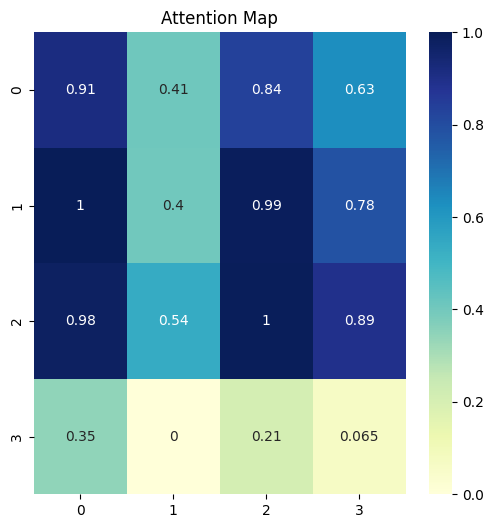

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 8, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 9, 7, 2, 2, 9, 1, 9, 2, 5, 8, 9, 4, 5, 1, 0, 7, 8, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 2, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 47%|████▋     | 14/30 [12:06<13:57, 52.33s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9731, 0.9646, 0.9780, 0.9816],
         [0.9027, 0.9988, 1.0000, 0.9188],
         [0.9720, 0.9657, 0.9790, 0.9807],
         [0.5012, 0.7973, 0.7655, 0.5253]],

        [[0.9926, 0.9825, 0.8950, 0.9228],
         [0.9880, 0.9758, 0.9086, 0.9101],
         [0.9396, 0.9159, 0.9716, 0.8191],
         [0.9998, 0.9990, 0.8283, 0.9672]],

        [[0.9797, 0.9409, 0.7235, 0.9481],
         [0.9899, 0.9591, 0.7579, 0.9651],
         [0.9719, 0.9957, 0.9362, 0.9934],
         [0.9889, 0.9573, 0.7542, 0.9634]],

        ...,

        [[0.9999, 0.9502, 0.9966, 0.9748],
         [0.9271, 0.7852, 0.9005, 0.9888],
         [0.9666, 0.8516, 0.9473, 0.9998],
         [0.9993, 0.9646, 0.9995, 0.9623]],

        [[0.8138, 0.8745, 0.7439, 0.8613],
         [0.9992, 0.9964, 0.9863, 0.9984],
         [0.9995, 0.9958, 0.9874, 0.9980],
         [0.9999, 0.9942, 0.9898, 0.9968]],

        [[0.9114, 0.9306, 0.8690, 0.9488],
         [0.9843, 0.9921, 0.9624, 0.9975],
         [0.9749, 0.962

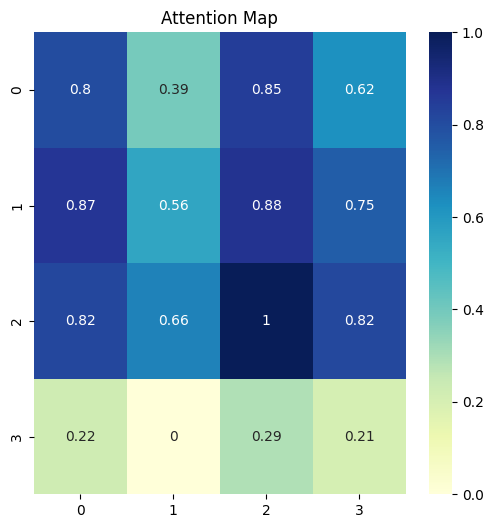

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 8, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 9, 7, 2, 2, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 8, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 50%|█████     | 15/30 [12:57<12:59, 52.00s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9876, 0.6432, 0.9969, 0.9538],
         [0.9238, 0.4988, 0.9872, 0.9977],
         [0.9956, 0.6821, 0.9897, 0.9331],
         [0.7069, 0.9987, 0.5638, 0.4303]],

        [[0.9401, 0.9274, 0.9559, 0.9250],
         [0.9874, 0.9809, 0.9942, 0.9796],
         [0.9621, 0.9517, 0.9746, 0.9497],
         [0.9735, 0.9646, 0.9838, 0.9628]],

        [[0.9971, 0.9748, 0.9917, 0.9993],
         [0.9953, 0.9986, 0.9553, 0.9780],
         [0.9350, 0.9768, 0.8493, 0.8912],
         [0.9836, 0.9995, 0.9280, 0.9574]],

        ...,

        [[0.9850, 0.9832, 0.9959, 0.9999],
         [0.9907, 0.9758, 0.9986, 0.9986],
         [0.8812, 0.9895, 0.9156, 0.9519],
         [0.9943, 0.8976, 0.9821, 0.9571]],

        [[0.8632, 0.9058, 0.9411, 0.7952],
         [0.9999, 0.9935, 0.9780, 0.9931],
         [0.9847, 0.9633, 0.9339, 0.9992],
         [0.9969, 0.9845, 0.9634, 0.9984]],

        [[0.8782, 0.6144, 0.9773, 0.8000],
         [0.9981, 0.9174, 0.9381, 0.9954],
         [0.9918, 0.832

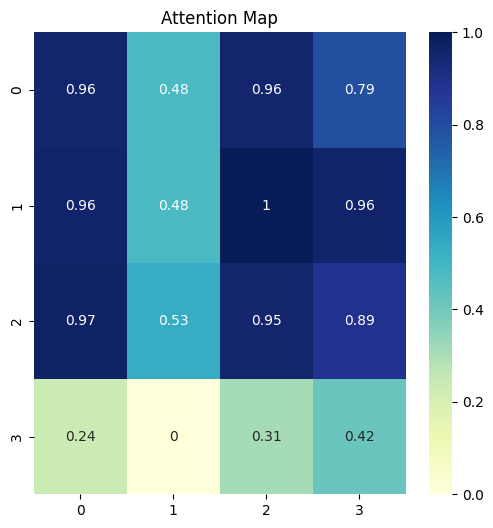

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 8, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 9, 7, 2, 2, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 8, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 53%|█████▎    | 16/30 [13:49<12:05, 51.83s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9065, 0.9527, 0.9970, 0.9871],
         [0.7597, 0.8305, 0.9320, 0.8999],
         [0.8855, 0.9368, 0.9920, 0.9780],
         [0.9210, 0.8654, 0.7423, 0.7893]],

        [[0.9364, 0.9985, 0.9978, 0.6870],
         [0.9969, 0.9741, 0.9410, 0.8435],
         [0.9371, 0.9986, 0.9977, 0.6883],
         [0.9848, 0.8896, 0.8335, 0.9474]],

        [[0.9398, 0.9260, 0.9500, 0.9914],
         [0.9972, 0.9934, 0.9991, 0.9894],
         [0.8785, 0.8602, 0.8925, 0.9595],
         [0.9998, 0.9998, 0.9988, 0.9718]],

        ...,

        [[1.0000, 0.9819, 0.9786, 0.9701],
         [0.9953, 0.9964, 0.9948, 0.9399],
         [0.9661, 0.9967, 0.9980, 0.8744],
         [0.9901, 0.9491, 0.9437, 0.9935]],

        [[0.9937, 0.9994, 0.9577, 0.9976],
         [0.9835, 0.9994, 0.9359, 1.0000],
         [0.9921, 0.9629, 0.9985, 0.9537],
         [0.9920, 0.9998, 0.9536, 0.9985]],

        [[0.9937, 0.9298, 0.9939, 0.9508],
         [0.9869, 0.9943, 0.9282, 0.9991],
         [0.9952, 0.985

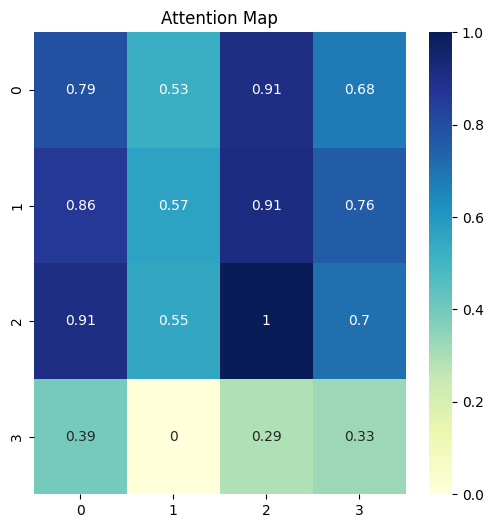

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 8, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 2, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 8, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 57%|█████▋    | 17/30 [14:39<11:07, 51.35s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9819, 0.6629, 0.9862, 0.9463],
         [0.8628, 0.8573, 0.9831, 0.7914],
         [0.9728, 0.6888, 0.9924, 0.9319],
         [0.7606, 0.1847, 0.5471, 0.8358]],

        [[0.9965, 0.9828, 0.8894, 0.6894],
         [0.9875, 0.9664, 0.8554, 0.6445],
         [0.9985, 0.9989, 0.9421, 0.7696],
         [0.9289, 0.8883, 0.7352, 0.5086]],

        [[0.9463, 0.9921, 0.9810, 0.9140],
         [0.9909, 0.9975, 1.0000, 0.8244],
         [0.9759, 0.9999, 0.9965, 0.8664],
         [0.9999, 0.9758, 0.9885, 0.7424]],

        ...,

        [[0.9810, 0.9046, 0.9901, 0.9998],
         [0.9242, 0.8102, 0.9431, 0.9758],
         [0.9941, 0.9370, 0.9985, 0.9978],
         [0.9997, 0.9741, 0.9970, 0.9805]],

        [[0.9997, 0.9988, 0.8654, 0.9919],
         [0.9968, 0.9984, 0.9104, 0.9997],
         [0.9680, 0.9621, 0.7448, 0.9382],
         [0.9998, 1.0000, 0.8867, 0.9968]],

        [[0.9588, 0.9059, 0.8682, 0.8806],
         [0.9996, 0.9918, 0.9772, 0.9826],
         [0.9957, 0.998

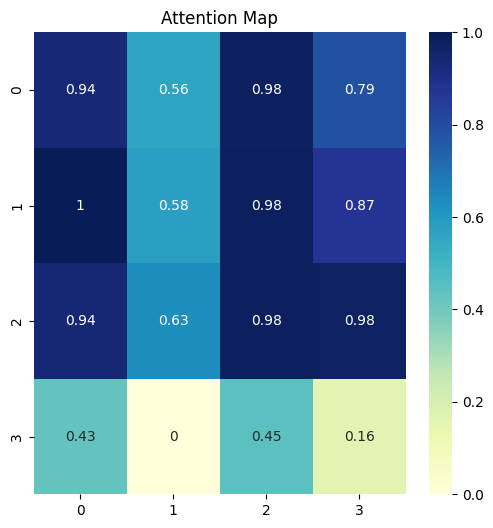

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 8, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 2, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 8, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 60%|██████    | 18/30 [15:29<10:10, 50.88s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9890, 0.9183, 0.9922, 0.9218],
         [0.9694, 0.9999, 0.8722, 1.0000],
         [0.9872, 0.9138, 0.9936, 0.9174],
         [0.6735, 0.8227, 0.5088, 0.8179]],

        [[0.9839, 0.9856, 0.9956, 0.9784],
         [0.9897, 0.9910, 0.9917, 0.9705],
         [0.9991, 0.9995, 0.9735, 0.9415],
         [0.9964, 0.9956, 0.9380, 0.8940]],

        [[0.9814, 0.9992, 0.9219, 0.9616],
         [0.9998, 0.9912, 0.9738, 0.9943],
         [0.9954, 0.9690, 0.9936, 0.9999],
         [0.9921, 0.9996, 0.9454, 0.9779]],

        ...,

        [[0.9584, 0.9045, 0.9473, 0.8805],
         [0.9942, 0.9655, 0.9894, 0.9497],
         [0.9969, 0.9970, 0.9992, 0.9910],
         [0.9977, 0.9750, 0.9944, 0.9612]],

        [[0.9995, 0.9989, 0.9954, 0.9940],
         [0.9986, 0.9996, 0.9933, 0.9916],
         [0.9916, 0.9783, 0.9978, 0.9986],
         [0.9997, 0.9984, 0.9962, 0.9949]],

        [[0.9188, 0.6763, 0.9940, 0.8554],
         [0.9609, 0.9820, 0.8432, 0.9909],
         [0.9875, 0.819

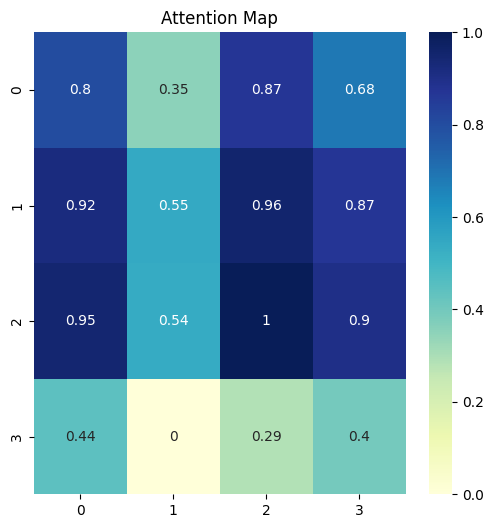

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 8, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 2, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 8, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 63%|██████▎   | 19/30 [16:19<09:18, 50.75s/it]

alpha: tensor([[[0.9632, 0.9136, 0.9991, 0.9704],
         [0.9999, 0.9903, 0.9476, 0.9992],
         [0.9781, 0.9367, 0.9944, 0.9836],
         [0.7562, 0.8371, 0.5679, 0.7399]],

        [[0.9851, 0.9622, 0.9232, 0.8854],
         [0.9954, 1.0000, 0.9915, 0.9752],
         [1.0000, 0.9940, 0.9734, 0.9482],
         [0.8842, 0.9261, 0.9643, 0.9846]],

        [[0.9624, 0.9936, 0.9802, 0.9123],
         [0.9932, 0.9615, 0.9814, 0.7130],
         [0.9946, 0.9982, 0.9996, 0.8345],
         [0.9948, 0.9981, 0.9997, 0.8337]],

        ...,

        [[0.9783, 0.8771, 0.9722, 0.9995],
         [0.9285, 0.7893, 0.9182, 0.9785],
         [0.9964, 0.9765, 0.9984, 0.9665],
         [0.9995, 0.9640, 1.0000, 0.9785]],

        [[0.9998, 0.9969, 0.9869, 0.9998],
         [0.9980, 0.9870, 0.9703, 0.9948],
         [0.9554, 0.9227, 0.8891, 0.9433],
         [0.9967, 0.9838, 0.9656, 0.9927]],

        [[0.9204, 0.7725, 0.9458, 0.8847],
         [0.9983, 0.9342, 0.9999, 0.9895],
         [0.9827, 0.992

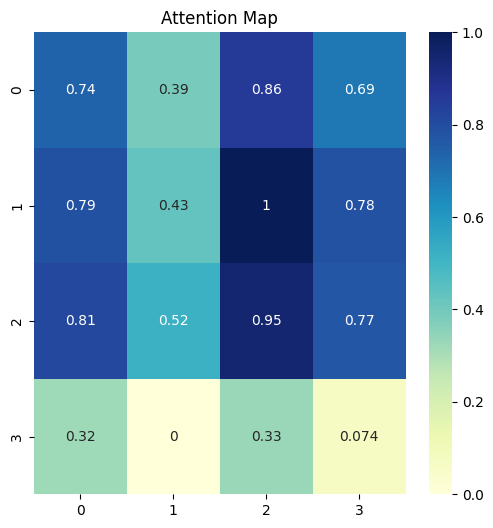

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 2, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 5, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 8, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 67%|██████▋   | 20/30 [17:10<08:27, 50.75s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9636, 0.9667, 0.9709, 0.9870],
         [0.8356, 0.9978, 0.8500, 0.9865],
         [0.9692, 0.9610, 0.9759, 0.9832],
         [0.7972, 0.4834, 0.7813, 0.5415]],

        [[0.9745, 0.9941, 0.9742, 0.8905],
         [0.9089, 0.9949, 0.9998, 0.7873],
         [0.9284, 0.9988, 0.9975, 0.8148],
         [0.9995, 0.9542, 0.9134, 0.9603]],

        [[0.9877, 0.9988, 0.8738, 0.9996],
         [0.9997, 0.9964, 0.9285, 0.9944],
         [0.9864, 0.9633, 0.9809, 0.9573],
         [0.9902, 0.9697, 0.9758, 0.9642]],

        ...,

        [[0.9944, 0.9995, 0.9782, 0.9563],
         [0.9995, 0.9945, 0.9907, 0.9749],
         [0.9919, 0.9655, 0.9997, 0.9979],
         [0.9994, 0.9946, 0.9906, 0.9747]],

        [[0.9067, 0.9746, 1.0000, 0.9160],
         [0.9985, 0.9639, 0.8820, 0.9969],
         [0.9985, 0.9871, 0.9263, 0.9995],
         [0.9997, 0.9819, 0.9152, 1.0000]],

        [[0.9428, 0.9084, 0.8730, 0.8337],
         [0.9991, 0.9986, 0.9908, 0.9765],
         [0.9995, 0.998

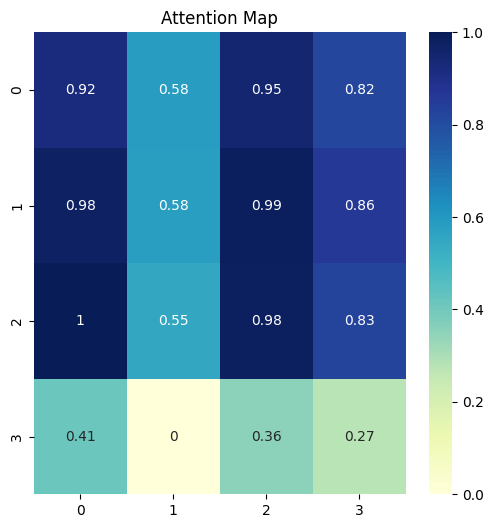

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 2, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 5, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 8, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 70%|███████   | 21/30 [18:00<07:36, 50.72s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9872, 0.7099, 0.9735, 0.9215],
         [0.9026, 0.8663, 0.8717, 0.9937],
         [0.9924, 0.6879, 0.9812, 0.9071],
         [0.7316, 0.2055, 0.7721, 0.3990]],

        [[0.9976, 0.9877, 0.9969, 0.7901],
         [0.9304, 0.8962, 0.9270, 0.9318],
         [0.9476, 0.9170, 0.9446, 0.9126],
         [0.9868, 0.9972, 0.9883, 0.6559]],

        [[0.9311, 0.8748, 0.7866, 0.6876],
         [0.9948, 0.9993, 0.9775, 0.9282],
         [0.8946, 0.8296, 0.7336, 0.6310],
         [0.9999, 0.9886, 0.9479, 0.8827]],

        ...,

        [[0.9817, 0.9972, 0.9129, 0.9995],
         [0.9977, 0.9805, 0.9550, 0.9957],
         [0.9912, 0.9230, 0.9948, 0.9575],
         [0.9921, 0.9256, 0.9941, 0.9594]],

        [[0.9994, 0.9926, 0.9489, 0.9985],
         [0.9997, 0.9938, 0.9458, 0.9990],
         [0.9918, 0.9769, 0.9740, 0.9890],
         [1.0000, 0.9957, 0.9395, 0.9997]],

        [[0.9131, 0.9930, 0.9051, 0.9663],
         [0.9848, 0.8900, 0.9881, 0.9440],
         [0.9934, 0.981

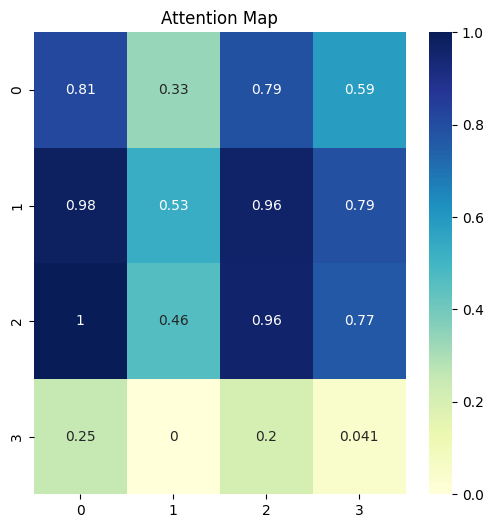

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 2, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 5, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 5, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 73%|███████▎  | 22/30 [18:51<06:45, 50.72s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[1.0000, 0.9293, 0.9721, 0.8912],
         [0.9445, 0.9989, 0.9952, 0.9896],
         [0.9948, 0.9607, 0.9905, 0.9302],
         [0.5974, 0.8202, 0.7408, 0.8679]],

        [[1.0000, 0.9956, 0.9183, 0.8903],
         [0.9943, 0.9805, 0.8749, 0.9311],
         [1.0000, 0.9953, 0.9171, 0.8918],
         [0.9041, 0.8640, 0.6912, 0.9994]],

        [[0.9943, 1.0000, 0.9991, 0.9993],
         [0.9979, 0.9865, 0.9918, 0.9909],
         [0.9372, 0.9667, 0.9568, 0.9588],
         [0.9973, 0.9997, 0.9999, 1.0000]],

        ...,

        [[0.9779, 0.9950, 0.8816, 0.9627],
         [0.9977, 0.9991, 0.9376, 0.9912],
         [0.9937, 0.9755, 0.9841, 0.9989],
         [0.9865, 0.9628, 0.9921, 0.9950]],

        [[0.8949, 0.9764, 0.7331, 0.9197],
         [0.9990, 0.9785, 0.9370, 0.9998],
         [0.9985, 0.9807, 0.9330, 1.0000],
         [0.9948, 0.9390, 0.9772, 0.9866]],

        [[0.9174, 0.9974, 0.9373, 0.8534],
         [0.9580, 0.8168, 0.9412, 0.9895],
         [0.9783, 0.991

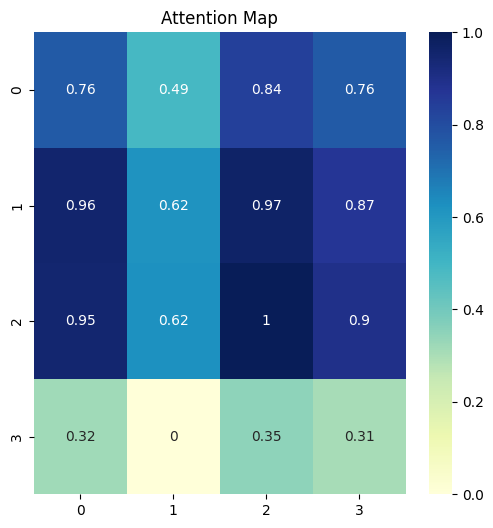

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 2, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 5, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 5, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 77%|███████▋  | 23/30 [19:42<05:55, 50.82s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9754, 0.7094, 0.9975, 0.9179],
         [0.8983, 0.8408, 0.9527, 0.9850],
         [0.9736, 0.7142, 0.9968, 0.9210],
         [0.7682, 0.2057, 0.6800, 0.3947]],

        [[0.9397, 0.9025, 0.9989, 0.7986],
         [0.9994, 0.9909, 0.9357, 0.9395],
         [0.9487, 0.9136, 0.9972, 0.8134],
         [0.9628, 0.9318, 0.9923, 0.8385]],

        [[0.9520, 0.9855, 0.9959, 0.9866],
         [0.9984, 0.9804, 0.9618, 0.9791],
         [0.9797, 0.9422, 0.9135, 0.9400],
         [0.9893, 0.9589, 0.9339, 0.9571]],

        ...,

        [[0.9628, 0.9201, 0.9685, 0.9297],
         [0.9985, 0.9825, 0.9995, 0.9870],
         [0.8920, 0.8298, 0.9013, 0.8429],
         [0.9989, 0.9839, 0.9997, 0.9882]],

        [[0.9913, 0.9337, 0.9579, 0.9990],
         [0.9980, 0.9848, 0.8874, 0.9888],
         [0.9778, 0.9038, 0.9774, 0.9923],
         [0.9999, 0.9694, 0.9178, 0.9971]],

        [[0.9659, 0.9938, 0.8845, 0.9984],
         [0.9998, 0.9851, 0.9781, 0.9743],
         [0.9884, 0.954

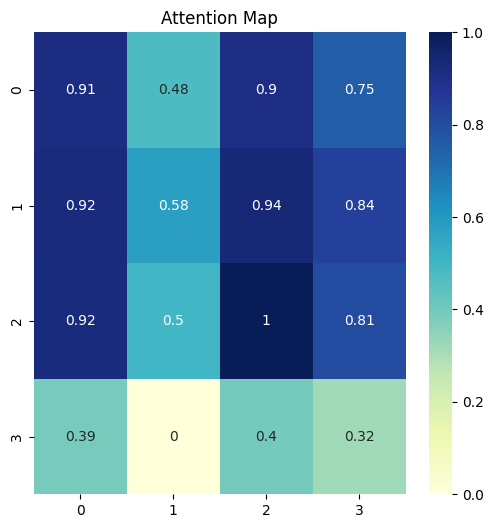

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 2, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 5, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 5, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 80%|████████  | 24/30 [20:34<05:05, 50.98s/it]

alpha: tensor([[[0.9753, 0.9748, 0.9943, 0.9904],
         [0.9817, 0.8139, 0.8722, 0.8574],
         [0.9805, 0.9690, 0.9913, 0.9867],
         [0.7307, 0.4627, 0.5326, 0.5137]],

        [[0.9264, 0.9965, 0.9320, 0.8897],
         [0.9134, 0.9929, 0.9194, 0.8743],
         [0.9958, 0.9772, 0.9971, 0.9831],
         [0.9813, 0.8821, 0.9782, 0.9948]],

        [[0.9942, 0.9622, 0.9289, 0.9998],
         [1.0000, 0.9867, 0.9642, 0.9912],
         [0.9751, 0.9985, 0.9987, 0.9402],
         [0.9967, 0.9962, 0.9813, 0.9785]],

        ...,

        [[0.9997, 0.9855, 1.0000, 0.9671],
         [0.9981, 0.9788, 0.9995, 0.9576],
         [0.9847, 0.9498, 0.9895, 0.9200],
         [0.9999, 0.9870, 0.9999, 0.9693]],

        [[0.8758, 0.9092, 0.9908, 0.9058],
         [0.9927, 0.9991, 0.9673, 0.9987],
         [1.0000, 0.9976, 0.9340, 0.9982],
         [0.9984, 0.9909, 0.9097, 0.9921]],

        [[0.9312, 0.8863, 0.9908, 0.9829],
         [0.9924, 1.0000, 0.9355, 0.9516],
         [0.9999, 0.991

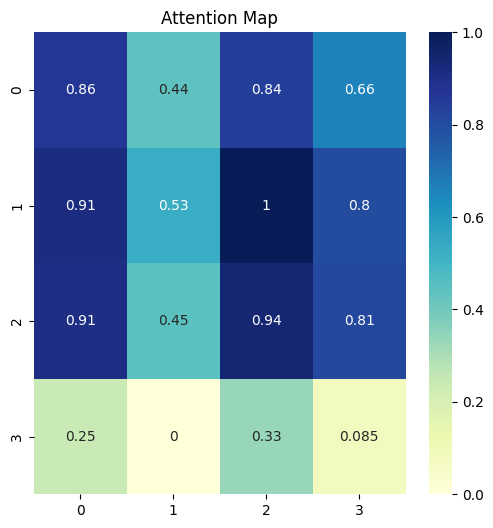

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 4, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 2, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 2, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 5, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 83%|████████▎ | 25/30 [21:24<04:14, 50.90s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.8869, 0.6716, 0.9971, 0.9293],
         [0.7013, 0.4608, 0.9124, 0.7630],
         [0.9095, 0.7039, 0.9998, 0.9474],
         [0.8853, 0.9959, 0.6624, 0.8351]],

        [[0.9977, 0.9856, 0.9963, 0.9662],
         [0.9936, 0.9769, 0.9913, 0.9768],
         [0.9872, 0.9659, 0.9840, 0.9858],
         [0.9609, 0.9840, 0.9658, 0.8290]],

        [[0.9700, 0.9847, 0.9269, 0.9056],
         [0.9978, 0.9906, 0.7813, 0.7502],
         [0.9860, 0.9719, 0.7237, 0.6910],
         [0.9982, 0.9999, 0.8468, 0.8188]],

        ...,

        [[0.9896, 0.9170, 0.8453, 0.9999],
         [0.9338, 0.8139, 0.7232, 0.9781],
         [0.9929, 0.9884, 0.9513, 0.9619],
         [0.9879, 0.9934, 0.9618, 0.9514]],

        [[0.9981, 0.9979, 0.9857, 1.0000],
         [0.9863, 0.9580, 0.9241, 0.9726],
         [0.9998, 0.9891, 0.9687, 0.9959],
         [0.9983, 0.9830, 0.9590, 0.9919]],

        [[0.9032, 0.9662, 0.9639, 0.8935],
         [0.9996, 0.9764, 0.9783, 1.0000],
         [0.9814, 0.929

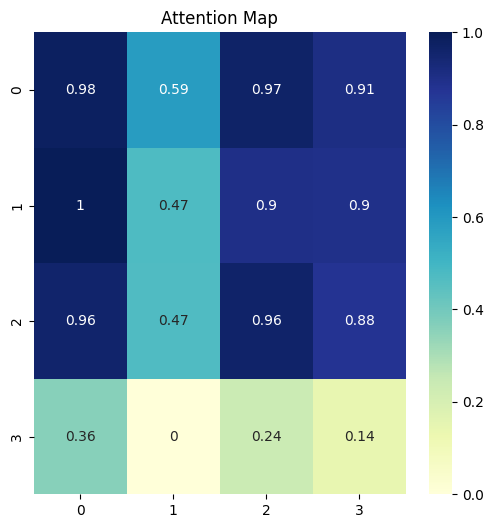

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 1, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 2, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 2, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 5, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 87%|████████▋ | 26/30 [22:15<03:23, 50.96s/it]

alpha: tensor([[[0.9704, 0.9149, 0.9877, 0.9474],
         [0.9933, 0.9981, 0.8743, 0.7883],
         [0.9888, 0.9481, 0.9686, 0.9140],
         [0.7483, 0.8428, 0.5079, 0.4099]],

        [[0.9881, 0.9863, 0.9459, 0.8813],
         [0.9878, 0.8920, 0.9998, 0.7179],
         [1.0000, 0.9499, 0.9841, 0.8059],
         [0.9277, 0.7778, 0.9784, 0.5792]],

        [[0.9716, 0.9968, 0.8707, 0.6639],
         [0.9948, 0.9983, 0.9275, 0.7452],
         [0.9958, 0.9687, 0.9813, 0.8484],
         [0.9956, 0.9978, 0.9302, 0.7495]],

        ...,

        [[0.9919, 0.9870, 0.9920, 0.9955],
         [0.9975, 0.9764, 0.9833, 0.9993],
         [0.9912, 0.9879, 0.9927, 0.9949],
         [0.9989, 0.9709, 0.9786, 0.9999]],

        [[0.9996, 0.9998, 0.9989, 0.9925],
         [0.9961, 0.9992, 0.9944, 0.9835],
         [0.9837, 0.9911, 0.9804, 0.9628],
         [0.9912, 0.9838, 0.9934, 0.9992]],

        [[0.9153, 0.7461, 0.7760, 0.9912],
         [0.9825, 0.8678, 0.8914, 0.9950],
         [0.9939, 0.973

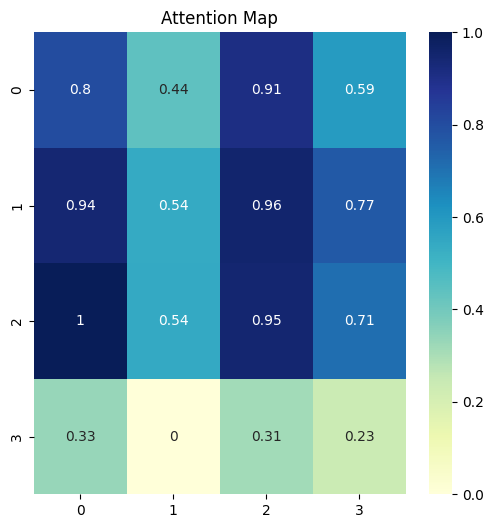

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 1, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 2, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 2, 3, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 5, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 90%|█████████ | 27/30 [23:06<02:32, 50.98s/it]

alpha: tensor([[[0.9582, 0.6591, 0.9972, 0.9705],
         [0.9935, 0.4187, 0.8903, 0.9870],
         [0.9715, 0.6279, 0.9919, 0.9816],
         [0.7737, 0.1579, 0.5558, 0.7471]],

        [[0.9051, 0.9928, 0.9999, 0.8223],
         [0.9960, 0.9724, 0.9335, 0.9646],
         [0.9934, 0.9779, 0.9421, 0.9577],
         [0.9942, 0.9102, 0.8510, 0.9975]],

        [[0.9743, 0.9551, 0.9124, 0.9996],
         [0.9968, 0.9880, 0.8470, 0.9927],
         [0.9946, 0.9996, 0.7490, 0.9544],
         [0.9846, 0.9690, 0.8910, 0.9997]],

        ...,

        [[0.9938, 1.0000, 0.9879, 0.9939],
         [0.9389, 0.9689, 0.9233, 0.9912],
         [0.9927, 0.9750, 0.9970, 0.9427],
         [0.9962, 0.9819, 0.9991, 0.9532]],

        [[0.8742, 0.9338, 0.8144, 0.8484],
         [0.9997, 0.9923, 0.9894, 0.9969],
         [0.9981, 0.9783, 0.9981, 1.0000],
         [0.9919, 0.9998, 0.9694, 0.9835]],

        [[0.9840, 0.9616, 0.9477, 0.9882],
         [0.9582, 0.9818, 0.9897, 0.9508],
         [1.0000, 0.994

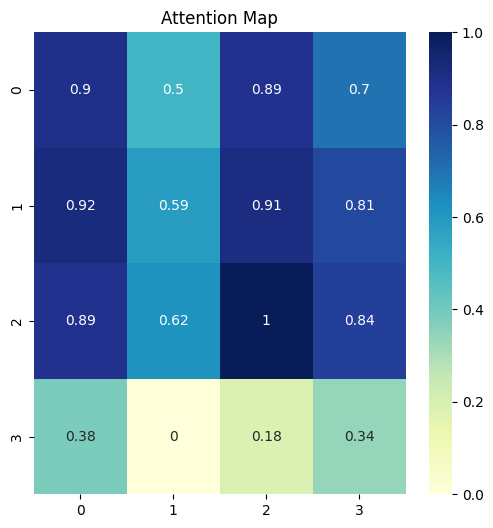

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 1, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 2, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 2, 9, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 5, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 93%|█████████▎| 28/30 [23:57<01:41, 50.83s/it]/home/jaeyeob/anaconda3/envs/lstm/lib/python3.10/site-packages/autoray/autoray.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  return func(*args, **kwargs)


alpha: tensor([[[0.9980, 0.6664, 0.9726, 0.8996],
         [0.9592, 0.7960, 0.9999, 0.7907],
         [0.9993, 0.6510, 0.9664, 0.9100],
         [0.6207, 0.9999, 0.7949, 0.3895]],

        [[0.9951, 0.9805, 0.8853, 0.9992],
         [0.9968, 0.9767, 0.8933, 0.9983],
         [0.9904, 0.9093, 0.9678, 0.9622],
         [0.8930, 0.7419, 0.9968, 0.8282]],

        [[0.9208, 0.9680, 0.7313, 0.9789],
         [0.9999, 0.9864, 0.9336, 0.9774],
         [0.9888, 0.9555, 0.9729, 0.9406],
         [0.9933, 0.9994, 0.8819, 0.9965]],

        ...,

        [[0.9925, 0.9999, 0.9663, 0.9770],
         [0.9950, 0.9992, 0.9718, 0.9815],
         [0.9905, 0.9622, 1.0000, 0.9990],
         [0.9872, 0.9998, 0.9561, 0.9683]],

        [[0.9178, 0.7652, 0.6362, 0.9316],
         [0.9968, 0.9721, 0.9008, 0.9931],
         [0.9865, 0.9884, 0.9332, 0.9797],
         [0.9967, 0.9724, 0.9012, 0.9930]],

        [[0.9114, 0.9924, 0.9579, 0.9314],
         [0.9938, 0.9810, 0.9997, 0.9984],
         [0.9703, 0.998

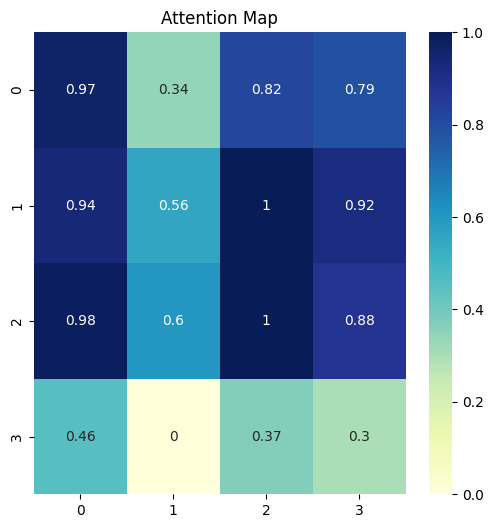

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 1, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 2, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 2, 9, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 5, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

 97%|█████████▋| 29/30 [24:47<00:50, 50.65s/it]

alpha: tensor([[[0.9380, 0.9635, 1.0000, 0.8910],
         [0.7861, 0.8308, 0.9449, 0.9896],
         [0.8999, 0.9323, 0.9948, 0.9307],
         [0.4093, 0.4569, 0.6189, 0.8833]],

        [[0.9858, 0.9801, 0.9630, 0.8597],
         [0.9987, 0.9998, 0.8845, 0.9473],
         [0.9998, 0.9987, 0.9144, 0.9226],
         [0.9909, 0.9862, 0.9536, 0.8753]],

        [[0.9902, 0.9476, 0.8927, 0.9408],
         [1.0000, 0.9816, 0.9435, 0.9773],
         [0.9853, 0.9999, 0.9867, 0.9993],
         [0.9865, 0.9998, 0.9855, 0.9990]],

        ...,

        [[0.9997, 0.9847, 0.9805, 0.9852],
         [0.9362, 0.8763, 0.8658, 0.8776],
         [0.9960, 0.9981, 0.9964, 0.9983],
         [0.9996, 0.9926, 0.9896, 0.9930]],

        [[0.9823, 0.9809, 0.9989, 0.9632],
         [0.9999, 0.9998, 0.9916, 0.9954],
         [0.9999, 0.9998, 0.9916, 0.9954],
         [0.9987, 0.9991, 0.9819, 0.9994]],

        [[0.9319, 0.9250, 0.9123, 0.9980],
         [0.9331, 0.9262, 0.9137, 0.9982],
         [0.9963, 0.994

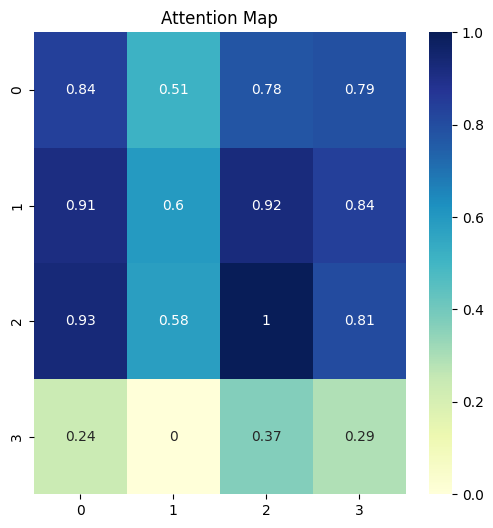

tensor([7, 9, 0, 3, 3, 3, 0, 0, 1, 5, 2, 4, 7, 0, 4, 7, 7, 3, 9, 4, 0, 2, 6, 9,
        5, 0, 0, 5, 8, 5, 0, 1, 8, 1, 3, 5, 9, 9, 8, 4, 4, 1, 7, 0, 8, 0, 4, 0,
        6, 7, 2, 2, 4, 6, 2, 8, 1, 9, 8, 3, 6, 5, 7, 8, 2, 8, 5, 1, 5, 3, 3, 3,
        8, 5, 6, 6, 4, 5, 4, 7, 4, 9, 6, 8, 5, 3, 1, 6, 2, 5, 9, 6, 6, 2, 6, 8,
        7, 9, 3, 7, 2, 2, 9, 1, 9, 2, 5, 6, 9, 4, 5, 1, 0, 7, 5, 5, 3, 0, 8, 4,
        7, 1, 9, 7, 0, 0, 2, 2, 4, 2, 4, 2, 6, 8, 7, 7, 2, 3, 8, 1, 1, 8, 7, 1,
        4, 5, 1, 0, 7, 7])
tensor([7., 9., 0., 3., 3., 3., 0., 0., 1., 5., 2., 4., 7., 0., 4., 7., 7., 3.,
        5., 4., 0., 2., 6., 9., 5., 0., 0., 5., 8., 5., 0., 1., 8., 1., 3., 5.,
        9., 9., 8., 4., 4., 1., 7., 0., 8., 0., 4., 0., 6., 7., 2., 2., 4., 6.,
        2., 8., 1., 9., 8., 3., 6., 5., 7., 8., 2., 8., 5., 1., 5., 3., 3., 3.,
        8., 5., 6., 6., 4., 5., 4., 7., 4., 9., 6., 8., 5., 3., 1., 6., 2., 5.,
        9., 6., 6., 2., 6., 8., 7., 9., 3., 7., 2., 2., 9., 1., 9., 2., 5., 6.,
        9., 4

100%|██████████| 30/30 [25:38<00:00, 51.28s/it]


In [21]:
for iepoch in tqdm(range(30)):
    optimizer.zero_grad()
    X_tensor=torch.tensor(X_train)
    predictions=model(X_tensor.float()).squeeze(1)
    #predictions=torch.sign(predictions)
    #print(predictions)
    label=torch.tensor(y_train)
    #for i in range(len(label)):
    #    if label[i]==1:
    #        label[i] = 0
    #    else:
    #        label[i]=1
    #print(label)
    loss = criterion(predictions, label.float())
    acc = multi_accuracy(predictions, label)
    print('')
    print('Accuracy:',acc)
    print('')
    print(loss)
    loss.backward()
    optimizer.step()

alpha: tensor([[[0.8606, 0.9113, 0.9953, 0.9378],
         [0.9805, 0.9967, 0.9687, 1.0000],
         [0.9565, 0.9837, 0.9884, 0.9941],
         [0.9592, 0.9211, 0.7610, 0.8920]],

        [[0.9294, 0.4039, 0.9399, 0.5326],
         [0.9809, 0.5100, 0.9863, 0.6450],
         [0.9998, 0.6408, 0.9987, 0.7719],
         [0.7832, 0.9655, 0.7663, 0.9992]],

        [[0.9939, 0.9557, 0.9846, 0.9782],
         [0.9984, 0.9698, 0.9925, 0.9878],
         [0.9401, 0.8635, 0.9168, 0.9034],
         [0.9468, 0.9902, 0.9654, 0.9736]],

        [[0.9627, 0.9468, 0.8406, 0.9484],
         [0.9972, 0.9915, 0.9271, 0.8710],
         [0.9930, 0.9980, 0.9811, 0.7720],
         [0.9929, 0.9849, 0.9104, 0.8905]],

        [[0.9464, 0.7372, 0.9124, 0.8204],
         [0.9700, 0.3970, 0.9888, 0.9987],
         [0.9971, 0.4930, 0.9998, 0.9759],
         [0.9039, 0.2951, 0.9396, 0.9885]],

        [[0.9809, 0.9956, 0.9980, 0.9993],
         [0.9858, 0.9926, 0.9993, 0.9979],
         [0.9898, 0.9891, 0.9999, 0.9

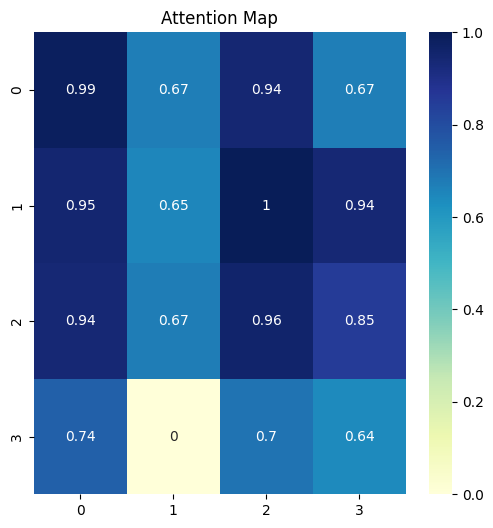

tensor([8, 9, 6, 2, 9, 6, 6, 1, 8, 5, 0, 5, 3, 9, 7, 0, 8, 3, 9, 3, 0, 0, 5, 1,
        1, 4, 4, 4, 0, 8, 4, 3, 6, 3, 6, 2, 7, 9, 2, 3, 1, 9, 2, 6, 3, 6, 3, 6,
        8, 5])
tensor([1., 9., 6., 2., 9., 6., 6., 1., 8., 5., 0., 5., 9., 9., 7., 0., 8., 3.,
        9., 3., 0., 0., 5., 1., 1., 4., 4., 4., 0., 8., 4., 3., 6., 3., 6., 2.,
        7., 9., 2., 3., 1., 9., 2., 6., 3., 6., 3., 6., 8., 3.],
       dtype=torch.float64)

Accuracy: 0.9399999976158142

Loss: 0.22332125902175903

AUROC: 0.9855129720577143



In [23]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

# Convert the predictions to probabilities (if they are logits)
X_tensor = torch.tensor(X_test)
predictions = model(X_tensor.float())

# Convert labels to one-hot encoding
label = torch.tensor(y_test)

# Calculate loss
loss = criterion(predictions, label.float())

# Calculate accuracy (multi-class)
acc = multi_accuracy(predictions, label.float())

# Calculate AUROC (multi-class)
# Flatten the arrays for roc_auc_score (if needed)
probs_np = predictions.detach().numpy()  # Convert to numpy
labels_np = label.numpy()

# Calculate AUROC using "micro" averaging (which considers all classes equally)
auroc = roc_auc_score(labels_np, probs_np, multi_class="ovr")

# Print results
print(f'\nAccuracy: {acc}\n')
print(f'Loss: {loss}\n')
print(f'AUROC: {auroc}\n')

-----------------------------------------